In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
!pip install pyspark --quiet

In [ ]:
import pyspark
import numpy as np
import random
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from pyspark import SparkConf
from pyspark.sql import Window
import pyspark.sql.functions as F
from pyspark.ml.feature import VectorAssembler, StandardScaler, OneHotEncoder, StringIndexer
from pyspark.ml.classification import LogisticRegression, GBTClassifier, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
sc = SparkContext.getOrCreate()
spark = SparkSession(sc)

In [ ]:
train_path="/content/drive/MyDrive/Freelance/Credit score prediction/train.csv"
test_path="/content/drive/MyDrive/Freelance/Credit score prediction/test.csv"

In [ ]:
# lOADING THE DATASET
infer_schema = "true"
first_row_is_header = "true"
delimiter = ","
df = spark.read.load(train_path,format='csv',header='true', inferSchema='true')
type(df)

pyspark.sql.dataframe.DataFrame

In [ ]:
data_test=spark.read.load(test_path,format='csv',header='true', inferSchema='true')

In [ ]:
df.printSchema()

root
 |-- ID: string (nullable = true)
 |-- Customer_ID: string (nullable = true)
 |-- Month: string (nullable = true)
 |-- Name: string (nullable = true)
 |-- Age: string (nullable = true)
 |-- SSN: string (nullable = true)
 |-- Occupation: string (nullable = true)
 |-- Annual_Income: string (nullable = true)
 |-- Monthly_Inhand_Salary: double (nullable = true)
 |-- Num_Bank_Accounts: integer (nullable = true)
 |-- Num_Credit_Card: integer (nullable = true)
 |-- Interest_Rate: integer (nullable = true)
 |-- Num_of_Loan: string (nullable = true)
 |-- Type_of_Loan: string (nullable = true)
 |-- Delay_from_due_date: integer (nullable = true)
 |-- Num_of_Delayed_Payment: string (nullable = true)
 |-- Changed_Credit_Limit: string (nullable = true)
 |-- Num_Credit_Inquiries: double (nullable = true)
 |-- Credit_Mix: string (nullable = true)
 |-- Outstanding_Debt: string (nullable = true)
 |-- Credit_Utilization_Ratio: double (nullable = true)
 |-- Credit_History_Age: string (nullable = true

In [ ]:
df.head()

Row(ID='0x1602', Customer_ID='CUS_0xd40', Month='January', Name='Aaron Maashoh', Age='23', SSN='821-00-0265', Occupation='Scientist', Annual_Income='19114.12', Monthly_Inhand_Salary=1824.8433333333328, Num_Bank_Accounts=3, Num_Credit_Card=4, Interest_Rate=3, Num_of_Loan='4', Type_of_Loan='Auto Loan, Credit-Builder Loan, Personal Loan, and Home Equity Loan', Delay_from_due_date=3, Num_of_Delayed_Payment='7', Changed_Credit_Limit='11.27', Num_Credit_Inquiries=4.0, Credit_Mix='_', Outstanding_Debt='809.98', Credit_Utilization_Ratio=26.822619623699016, Credit_History_Age='22 Years and 1 Months', Payment_of_Min_Amount='No', Total_EMI_per_month=49.57494921489417, Amount_invested_monthly='80.41529543900253', Payment_Behaviour='High_spent_Small_value_payments', Monthly_Balance='312.49408867943663', Credit_Score='Good')

In [ ]:
data_train=df.toPandas()
data_train.head()

ID Customer_ID     Month           Name   Age          SSN Occupation  \
0  0x1602   CUS_0xd40   January  Aaron Maashoh    23  821-00-0265  Scientist   
1  0x1603   CUS_0xd40  February  Aaron Maashoh    23  821-00-0265  Scientist   
2  0x1604   CUS_0xd40     March  Aaron Maashoh  -500  821-00-0265  Scientist   
3  0x1605   CUS_0xd40     April  Aaron Maashoh    23  821-00-0265  Scientist   
4  0x1606   CUS_0xd40       May  Aaron Maashoh    23  821-00-0265  Scientist   

  Annual_Income  Monthly_Inhand_Salary  Num_Bank_Accounts  ...  Credit_Mix  \
0      19114.12            1824.843333                  3  ...           _   
1      19114.12                    NaN                  3  ...        Good   
2      19114.12                    NaN                  3  ...        Good   
3      19114.12                    NaN                  3  ...        Good   
4      19114.12            1824.843333                  3  ...        Good   

   Outstanding_Debt Credit_Utilization_Ratio     Credit_History_Age  \
0            809.98                26.822620  22 Years and 1 Months   
1            809.98                31.944960                     NA   
2            809.98                28.609352  22 Years and 3 Months   
3            809.98                31.377862  22 Years and 4 Months   
4            809.98                24.797347  22 Years and 5 Months   

   Payment_of_Min_Amount Total_EMI_per_month Amount_invested_monthly  \
0                     No           49.574949       80.41529543900253   
1                     No           49.574949      118.28022162236736   
2                     No           49.574949         81.699521264648   
3                     No           49.574949       199.4580743910713   
4                     No           49.574949      41.420153086217326   

                  Payment_Behaviour     Monthly_Balance Credit_Score  
0   High_spent_Small_value_payments  312.49408867943663         Good  
1    Low_spent_Large_value_payments  284.62916249607184         Good  
2   Low_spent_Medium_value_payments   331.2098628537912         Good  
3    Low_spent_Small_value_payments  223.45130972736786         Good  
4  High_spent_Medium_value_payments  341.48923103222177         Good  

[5 rows x 28 columns]

In [ ]:
# Removing column with completely unique values as they would not be required
data_train.drop(['ID'] ,axis= 1 , inplace = True)

In [ ]:
def check_data_describing(df):
  print(df.shape)
  print('\n*********************************')
  print(df.describe().transpose())
  print('\n *********************************')
  print(df.info())

check_data_describing(data_train)

(100000, 27)

*********************************
                             count         mean          std         min  \
Monthly_Inhand_Salary      84998.0  4194.170850  3183.686167  303.645417   
Num_Bank_Accounts         100000.0    17.091280   117.404834   -1.000000   
Num_Credit_Card           100000.0    22.474430   129.057410    0.000000   
Interest_Rate             100000.0    72.466040   466.422621    1.000000   
Delay_from_due_date       100000.0    21.068780    14.860104   -5.000000   
Num_Credit_Inquiries       98035.0    27.754251   193.177339    0.000000   
Credit_Utilization_Ratio  100000.0    32.285173     5.116875   20.000000   
Total_EMI_per_month       100000.0  1403.118217  8306.041270    0.000000   

                                  25%          50%          75%           max  
Monthly_Inhand_Salary     1625.568229  3093.745000  5957.448333  15204.633333  
Num_Bank_Accounts            3.000000     6.000000     7.000000   1798.000000  
Num_Credit_Card            

In [ ]:
categorical = data_train.dtypes[data_train.dtypes == "object"].index
data_train[categorical].describe().transpose()

count unique                               top  \
Customer_ID              100000  12500                         CUS_0xd40   
Month                    100000      8                           January   
Name                      90015  10139                            Langep   
Age                      100000   1788                                38   
SSN                      100000  12501                         #F%$D@*&8   
Occupation               100000     16                           _______   
Annual_Income            100000  18940                          36585.12   
Num_of_Loan              100000    434                                 3   
Type_of_Loan              88592   6260                     Not Specified   
Num_of_Delayed_Payment    92998    749                                19   
Changed_Credit_Limit     100000   4384                                 _   
Credit_Mix               100000      4                          Standard   
Outstanding_Debt         100000  13178                           1360.45   
Credit_History_Age       100000    405                                NA   
Payment_of_Min_Amount    100000      3                               Yes   
Amount_invested_monthly   95521  91049                         __10000__   
Payment_Behaviour        100000      7    Low_spent_Small_value_payments   
Monthly_Balance           98800  98792  __-333333333333333333333333333__   
Credit_Score             100000      3                          Standard   

                          freq  
Customer_ID                  8  
Month                    12500  
Name                        44  
Age                       2833  
SSN                       5572  
Occupation                7062  
Annual_Income               16  
Num_of_Loan              14386  
Type_of_Loan              1408  
Num_of_Delayed_Payment    5327  
Changed_Credit_Limit      2091  
Credit_Mix               36479  
Outstanding_Debt            24  
Credit_History_Age        9030  
Payment_of_Min_Amount    52326  
Amount_invested_monthly   4305  
Payment_Behaviour        25513  
Monthly_Balance              9  
Credit_Score             53174

In [ ]:
# writing a function to check the following: data types, unique values, null values, duplicates
def dirty_data_finding(df):
    dirty = []
    columns = df.columns
    for col in columns:
        dtype = df[col].dtypes
        nunique = df[col].nunique()
        null = df[col].isnull().sum()
        duplicates = df[col].duplicated().sum()
        dirty.append([col,dtype,nunique,null,duplicates])
    df_dirty_data_finding = pd.DataFrame(dirty)
    df_dirty_data_finding.columns = ['column','dtype','nunique','null','duplicates']
    return df_dirty_data_finding

dirty_data_finding(data_train)

column    dtype  nunique   null  duplicates
0                Customer_ID   object    12500      0       87500
1                      Month   object        8      0       99992
2                       Name   object    10139   9985       89860
3                        Age   object     1788      0       98212
4                        SSN   object    12501      0       87499
5                 Occupation   object       16      0       99984
6              Annual_Income   object    18940      0       81060
7      Monthly_Inhand_Salary  float64    13235  15002       86764
8          Num_Bank_Accounts    int32      943      0       99057
9            Num_Credit_Card    int32     1179      0       98821
10             Interest_Rate    int32     1750      0       98250
11               Num_of_Loan   object      434      0       99566
12              Type_of_Loan   object     6260  11408       93739
13       Delay_from_due_date    int32       73      0       99927
14    Num_of_Delayed_Payment   object      749   7002       99250
15      Changed_Credit_Limit   object     4384      0       95616
16      Num_Credit_Inquiries  float64     1223   1965       98776
17                Credit_Mix   object        4      0       99996
18          Outstanding_Debt   object    13178      0       86822
19  Credit_Utilization_Ratio  float64   100000      0           0
20        Credit_History_Age   object      405      0       99595
21     Payment_of_Min_Amount   object        3      0       99997
22       Total_EMI_per_month  float64    14950      0       85050
23   Amount_invested_monthly   object    91049   4479        8950
24         Payment_Behaviour   object        7      0       99993
25           Monthly_Balance   object    98792   1200        1207
26              Credit_Score   object        3      0       99997

In [ ]:
for e in data_train.columns:
  print(e)
  print(data_train[e].value_counts())
  print('\n**********************************\n')

Customer_ID
CUS_0xd40     8
CUS_0x9bf4    8
CUS_0x5ae3    8
CUS_0xbe9a    8
CUS_0x4874    8
             ..
CUS_0x2eb4    8
CUS_0x7863    8
CUS_0x9d89    8
CUS_0xc045    8
CUS_0x942c    8
Name: Customer_ID, Length: 12500, dtype: int64

**********************************

Month
January     12500
February    12500
March       12500
April       12500
May         12500
June        12500
July        12500
August      12500
Name: Month, dtype: int64

**********************************

Name
Langep            44
Stevex            44
Vaughanl          39
Jessicad          39
Raymondr          38
                  ..
Alina Selyukhg     4
Habboushg          4
Mortimerq          4
Ronaldf            4
Timothyl           3
Name: Name, Length: 10139, dtype: int64

**********************************

Age
38      2833
28      2829
31      2806
26      2792
32      2749
        ... 
471        1
1520       1
8663       1
3363       1
1342       1
Name: Age, Length: 1788, dtype: int64

****************

In [ ]:
# cleaning the unclear strinf columns
data_train = data_train.applymap(lambda x: x if x is np.NaN or not isinstance(x, str) else str(x).strip('_ ,"')).replace(['', 'nan', '!@9#%8', '#F%$D@*&8'], np.NaN)
data_train

Customer_ID     Month           Name   Age          SSN Occupation  \
0       CUS_0xd40   January  Aaron Maashoh    23  821-00-0265  Scientist   
1       CUS_0xd40  February  Aaron Maashoh    23  821-00-0265  Scientist   
2       CUS_0xd40     March  Aaron Maashoh  -500  821-00-0265  Scientist   
3       CUS_0xd40     April  Aaron Maashoh    23  821-00-0265  Scientist   
4       CUS_0xd40       May  Aaron Maashoh    23  821-00-0265  Scientist   
...           ...       ...            ...   ...          ...        ...   
99995  CUS_0x942c     April          Nicks    25  078-73-5990   Mechanic   
99996  CUS_0x942c       May          Nicks    25  078-73-5990   Mechanic   
99997  CUS_0x942c      June          Nicks    25  078-73-5990   Mechanic   
99998  CUS_0x942c      July          Nicks    25  078-73-5990   Mechanic   
99999  CUS_0x942c    August          Nicks    25  078-73-5990   Mechanic   

      Annual_Income  Monthly_Inhand_Salary  Num_Bank_Accounts  \
0          19114.12            1824.843333                  3   
1          19114.12                    NaN                  3   
2          19114.12                    NaN                  3   
3          19114.12                    NaN                  3   
4          19114.12            1824.843333                  3   
...             ...                    ...                ...   
99995      39628.99            3359.415833                  4   
99996      39628.99            3359.415833                  4   
99997      39628.99            3359.415833                  4   
99998      39628.99            3359.415833                  4   
99999      39628.99            3359.415833                  4   

       Num_Credit_Card  ...  Credit_Mix Outstanding_Debt  \
0                    4  ...         NaN           809.98   
1                    4  ...        Good           809.98   
2                    4  ...        Good           809.98   
3                    4  ...        Good           809.98   
4                    4  ...        Good           809.98   
...                ...  ...         ...              ...   
99995                6  ...         NaN           502.38   
99996                6  ...         NaN           502.38   
99997                6  ...        Good           502.38   
99998                6  ...        Good           502.38   
99999                6  ...        Good           502.38   

      Credit_Utilization_Ratio      Credit_History_Age Payment_of_Min_Amount  \
0                    26.822620   22 Years and 1 Months                    No   
1                    31.944960                      NA                    No   
2                    28.609352   22 Years and 3 Months                    No   
3                    31.377862   22 Years and 4 Months                    No   
4                    24.797347   22 Years and 5 Months                    No   
...                        ...                     ...                   ...   
99995                34.663572   31 Years and 6 Months                    No   
99996                40.565631   31 Years and 7 Months                    No   
99997                41.255522   31 Years and 8 Months                    No   
99998                33.638208   31 Years and 9 Months                    No   
99999                34.192463  31 Years and 10 Months                    No   

      Total_EMI_per_month  Amount_invested_monthly  \
0               49.574949        80.41529543900253   
1               49.574949       118.28022162236736   
2               49.574949          81.699521264648   
3               49.574949        199.4580743910713   
4               49.574949       41.420153086217326   
...                   ...                      ...   
99995           35.104023        60.97133255718485   
99996           35.104023        54.18595028760385   
99997           35.104023        24.02847744864441   
99998           35.104023       251.67258219721603   
99999           35.104023        167

In [ ]:
# Changing the data type of columns to the required type
data_train.Age = data_train.Age.astype(int)
data_train.Annual_Income = data_train.Annual_Income.astype(float)
data_train.Num_of_Loan = data_train.Num_of_Loan.astype(int)
data_train.Num_of_Delayed_Payment = data_train.Num_of_Delayed_Payment.astype(float)
data_train.Changed_Credit_Limit = data_train.Changed_Credit_Limit.astype(float)
data_train.Outstanding_Debt = data_train.Outstanding_Debt.astype(float)
data_train.Amount_invested_monthly = data_train.Amount_invested_monthly.astype(float)
data_train.Monthly_Balance = data_train.Monthly_Balance.astype(float)

In [ ]:
# Now again checking for all the attributes like null, duplicates etc using the created function
dirty_data_finding(data_train)

column    dtype  nunique   null  duplicates
0                Customer_ID   object    12500      0       87500
1                      Month   object        8      0       99992
2                       Name   object    10128   9985       89871
3                        Age    int64     1728      0       98272
4                        SSN   object    12500   5572       87499
5                 Occupation   object       15   7062       99984
6              Annual_Income  float64    13487      0       86513
7      Monthly_Inhand_Salary  float64    13235  15002       86764
8          Num_Bank_Accounts    int64      943      0       99057
9            Num_Credit_Card    int64     1179      0       98821
10             Interest_Rate    int64     1750      0       98250
11               Num_of_Loan    int64      414      0       99586
12              Type_of_Loan   object     6260  11408       93739
13       Delay_from_due_date    int64       73      0       99927
14    Num_of_Delayed_Payment  float64      711   7002       99288
15      Changed_Credit_Limit  float64     4383   2091       95616
16      Num_Credit_Inquiries  float64     1223   1965       98776
17                Credit_Mix   object        3  20195       99996
18          Outstanding_Debt  float64    12203      0       87797
19  Credit_Utilization_Ratio  float64   100000      0           0
20        Credit_History_Age   object      405      0       99595
21     Payment_of_Min_Amount   object        3      0       99997
22       Total_EMI_per_month  float64    14950      0       85050
23   Amount_invested_monthly  float64    91049   4479        8950
24         Payment_Behaviour   object        6   7600       99993
25           Monthly_Balance  float64    98792   1200        1207
26              Credit_Score   object        3      0       99997

In [ ]:
check_data_describing(data_train)

(100000, 27)

*********************************
                             count          mean           std           min  \
Age                       100000.0  1.106497e+02  6.862447e+02 -5.000000e+02   
Annual_Income             100000.0  1.764157e+05  1.429618e+06  7.005930e+03   
Monthly_Inhand_Salary      84998.0  4.194171e+03  3.183686e+03  3.036454e+02   
Num_Bank_Accounts         100000.0  1.709128e+01  1.174048e+02 -1.000000e+00   
Num_Credit_Card           100000.0  2.247443e+01  1.290574e+02  0.000000e+00   
Interest_Rate             100000.0  7.246604e+01  4.664226e+02  1.000000e+00   
Num_of_Loan               100000.0  3.009960e+00  6.264788e+01 -1.000000e+02   
Delay_from_due_date       100000.0  2.106878e+01  1.486010e+01 -5.000000e+00   
Num_of_Delayed_Payment     92998.0  3.092334e+01  2.260319e+02 -3.000000e+00   
Changed_Credit_Limit       97909.0  1.038903e+01  6.789496e+00 -6.490000e+00   
Num_Credit_Inquiries       98035.0  2.775425e+01  1.931773e+02  0.000000

In [ ]:
for column in data_train.columns:
  print('The Columns :',column)
  print(data_train[column].value_counts())
  print('****************************************')

The Columns : Customer_ID
CUS_0xd40     8
CUS_0x9bf4    8
CUS_0x5ae3    8
CUS_0xbe9a    8
CUS_0x4874    8
             ..
CUS_0x2eb4    8
CUS_0x7863    8
CUS_0x9d89    8
CUS_0xc045    8
CUS_0x942c    8
Name: Customer_ID, Length: 12500, dtype: int64
****************************************
The Columns : Month
January     12500
February    12500
March       12500
April       12500
May         12500
June        12500
July        12500
August      12500
Name: Month, dtype: int64
****************************************
The Columns : Name
Langep              44
Stevex              44
Jessicad            39
Vaughanl            39
Raymondr            38
                    ..
McBrideq             4
Yinka Adegokec       4
Josephine Masonz     4
Vellacotto           4
Timothyl             3
Name: Name, Length: 10128, dtype: int64
****************************************
The Columns : Age
38      2994
28      2968
31      2955
26      2945
32      2884
        ... 
1908       1
4583       1
7549

In [ ]:
# removing null values
def cleaning_Null_columns(df_column,method,headlines):
  print('Before cleaning: \n',)
  print(df_column.value_counts(dropna = False).head(headlines))
  print('\n******************************************\n')
  print('After cleaning: \n')
  df_column.fillna(method = method, inplace = True)
  return df_column.value_counts(dropna = False)

In [ ]:
cleaning_Null_columns(data_train['Occupation'],'ffill',30)

Before cleaning: 

NaN              7062
Lawyer           6575
Architect        6355
Engineer         6350
Scientist        6299
Mechanic         6291
Accountant       6271
Developer        6235
Media_Manager    6232
Teacher          6215
Entrepreneur     6174
Doctor           6087
Journalist       6085
Manager          5973
Musician         5911
Writer           5885
Name: Occupation, dtype: int64

******************************************

After cleaning: 



Lawyer           7097
Engineer         6849
Architect        6832
Mechanic         6775
Scientist        6746
Accountant       6745
Media_Manager    6732
Developer        6712
Teacher          6685
Entrepreneur     6653
Doctor           6564
Journalist       6534
Manager          6422
Musician         6345
Writer           6309
Name: Occupation, dtype: int64

In [ ]:
cleaning_Null_columns(data_train['Type_of_Loan'],'ffill',40)

Before cleaning: 

NaN                                                 11408
Not Specified                                        1408
Credit-Builder Loan                                  1280
Personal Loan                                        1272
Debt Consolidation Loan                              1264
Student Loan                                         1240
Payday Loan                                          1200
Mortgage Loan                                        1176
Auto Loan                                            1152
Home Equity Loan                                     1136
Personal Loan, and Student Loan                       320
Not Specified, and Payday Loan                        272
Mortgage Loan, and Home Equity Loan                   264
Student Loan, and Payday Loan                         256
Student Loan, and Credit-Builder Loan                 248
Credit-Builder Loan, and Not Specified                248
Payday Loan, and Debt Consolidation Loan             

Not Specified                                                                                                             1568
Personal Loan                                                                                                             1472
Debt Consolidation Loan                                                                                                   1464
Credit-Builder Loan                                                                                                       1416
Payday Loan                                                                                                               1400
                                                                                                                          ... 
Home Equity Loan, Debt Consolidation Loan, Home Equity Loan, Payday Loan, and Payday Loan                                    8
Debt Consolidation Loan, Payday Loan, Payday Loan, and Mortgage Loan                                           

In [ ]:
cleaning_Null_columns(data_train['Credit_Mix'],'ffill',40)

Before cleaning: 

Standard    36479
Good        24337
NaN         20195
Bad         18989
Name: Credit_Mix, dtype: int64

******************************************

After cleaning: 



Standard    45820
Good        30351
Bad         23828
NaN             1
Name: Credit_Mix, dtype: int64

In [ ]:
cleaning_Null_columns(data_train['Credit_History_Age'],'ffill',40)

Before cleaning: 

NA                        9030
15 Years and 11 Months     446
19 Years and 4 Months      445
19 Years and 5 Months      444
17 Years and 11 Months     443
19 Years and 3 Months      441
17 Years and 9 Months      438
15 Years and 10 Months     436
17 Years and 10 Months     435
15 Years and 9 Months      432
18 Years and 3 Months      428
18 Years and 4 Months      426
18 Years and 2 Months      426
19 Years and 9 Months      422
17 Years and 8 Months      419
15 Years and 8 Months      415
18 Years and 11 Months     414
16 Years and 2 Months      412
18 Years and 5 Months      410
18 Years and 10 Months     408
19 Years and 11 Months     405
19 Years and 10 Months     403
17 Years and 3 Months      403
19 Years and 8 Months      403
17 Years and 5 Months      402
18 Years and 9 Months      402
19 Years and 2 Months      401
16 Years and 5 Months      396
18 Years and 8 Months      396
16 Years and 8 Months      396
16 Years and 3 Months      396
17 Years and 4 Month

NA                        9030
15 Years and 11 Months     446
19 Years and 4 Months      445
19 Years and 5 Months      444
17 Years and 11 Months     443
                          ... 
0 Years and 3 Months        20
0 Years and 2 Months        15
33 Years and 7 Months       14
33 Years and 8 Months       12
0 Years and 1 Months         2
Name: Credit_History_Age, Length: 405, dtype: int64

In [ ]:
cleaning_Null_columns(data_train['Payment_Behaviour'],'ffill',50)

Before cleaning: 

Low_spent_Small_value_payments      25513
High_spent_Medium_value_payments    17540
Low_spent_Medium_value_payments     13861
High_spent_Large_value_payments     13721
High_spent_Small_value_payments     11340
Low_spent_Large_value_payments      10425
NaN                                  7600
Name: Payment_Behaviour, dtype: int64

******************************************

After cleaning: 



Low_spent_Small_value_payments      27593
High_spent_Medium_value_payments    19010
Low_spent_Medium_value_payments     14987
High_spent_Large_value_payments     14863
High_spent_Small_value_payments     12250
Low_spent_Large_value_payments      11297
Name: Payment_Behaviour, dtype: int64

In [ ]:
age_list = []
for ages in range(16,85,1):
  age_list.append(ages)

for age in data_train.Age:
  if age not in age_list:
    data_train['Age'].replace(age,random.choice(age_list),inplace = True)

In [ ]:
for income_value in data_train.Annual_Income:
  if income_value > 500000:
    New_income_value = income_value / 10
    data_train.Annual_Income.replace(income_value,New_income_value, inplace = True)

In [ ]:
print('Describtion of the column:\n',data_train.Num_Bank_Accounts.describe())
print('\n*************************************\n')
print('Shape of the column:\n',data_train[data_train.Num_Bank_Accounts > 10].shape) 
print('\n*************************************\n')
print('Value counts of the column:\n',data_train.Num_Bank_Accounts.value_counts().head(10))

Describtion of the column:
 count    100000.000000
mean         17.091280
std         117.404834
min          -1.000000
25%           3.000000
50%           6.000000
75%           7.000000
max        1798.000000
Name: Num_Bank_Accounts, dtype: float64

*************************************

Shape of the column:
 (1324, 27)

*************************************

Value counts of the column:
 6     13001
7     12823
8     12765
4     12186
5     12118
3     11950
9      5443
10     5247
1      4490
0      4328
Name: Num_Bank_Accounts, dtype: int64


In [ ]:
most_common_number = [0,1,2,3,4,5,6,7,8,9]
for num in data_train.Num_Bank_Accounts:
  if num not in most_common_number:
    data_train.Num_Bank_Accounts.replace(num,random.choice(most_common_number),inplace = True)

In [ ]:
data_train.Num_Bank_Accounts.value_counts()

6    13142
7    12961
8    12899
4    12325
5    12239
3    12082
9    10823
1     4634
0     4479
2     4416
Name: Num_Bank_Accounts, dtype: int64

In [ ]:
print('Values of the column:\n',data_train.Num_Credit_Card.unique())
print('\n*************************************\n')
print('Shape of the column:\n',data_train[data_train['Num_Credit_Card'] > 10].shape) 
print('\n*************************************\n')
print('Value counts of the column:\n',data_train.Num_Credit_Card.value_counts().head(15))

Values of the column:
 [   4 1385    5 ...  955 1430  679]

*************************************

Shape of the column:
 (2307, 27)

*************************************

Value counts of the column:
 5      18459
7      16615
6      16559
4      14030
3      13277
8       4956
10      4860
9       4643
2       2149
1       2132
11        36
0         13
849        8
852        7
183        6
Name: Num_Credit_Card, dtype: int64


In [ ]:
common_credit = []
for credit in range(0,12,1):
  common_credit.append(credit)

for num_of_credit in data_train.Num_Credit_Card:
  if num_of_credit not in common_credit:
    data_train.Num_Credit_Card.replace(num_of_credit,random.choice(common_credit),inplace = True)

In [ ]:
data_train.Num_Credit_Card.value_counts()

5     18618
7     16809
6     16739
4     14228
3     13465
8      5162
10     5042
9      4836
2      2359
1      2333
11      210
0       199
Name: Num_Credit_Card, dtype: int64

In [ ]:
def Preview_column(df_column,headline):
  print('Values of the column:\n',df_column.unique())
  print('\n*************************************\n')
  print('Value counts of the column:\n',df_column.value_counts().head(headline))

In [ ]:
Preview_column(data_train['Num_of_Loan'],20)

Values of the column:
 [   4    1    3  967 -100    0    2    7    5    6    8    9 1464  622
  352  472 1017  945  146  563  341  444  720 1485   49  737 1106  466
  728  313  843  597  617  119  663  640   92 1019  501 1302   39  716
  848  931 1214  186  424 1001 1110 1152  457 1433 1187   52 1480 1047
 1035 1347   33  193  699  329 1451  484  132  649  995  545  684 1135
 1094 1204  654   58  348  614 1363  323 1406 1348  430  153 1461  905
 1312 1424 1154   95 1353 1228  819 1006  795  359 1209  590  696 1185
 1465  911 1181   70  816 1369  143 1416  455   55 1096 1474  420 1131
  904   89 1259  527 1241  449  983  418  319   23  238  638  138  235
  280 1070 1484  274  494 1459  404 1354 1495 1391  601 1313 1319  898
  231  752  174  961 1046  834  284  438  288 1463 1151  719  198 1015
  855  841  392 1444  103 1320  745  172  252  630  241   31  405 1217
 1030 1257  137  157  164 1088 1236  777 1048  613  330 1439  321  661
  952  939  562 1202  302  943  394  955 1318  936  78

In [ ]:
for error_Loan in data_train.Num_of_Loan:
  if error_Loan > 9 or error_Loan < 0:
      data_train['Num_of_Loan'].replace(error_Loan,random.randint(0,9),inplace= True)

In [ ]:
data_train.Num_of_Loan.value_counts()

3    15148
2    15075
4    14791
1    14528
0    10978
6     7843
7     7386
5     7245
9     3755
8     3251
Name: Num_of_Loan, dtype: int64

In [ ]:
Preview_column(data_train['Num_of_Delayed_Payment'],20)

Values of the column:
 [ 7.000e+00        nan  4.000e+00  8.000e+00  6.000e+00  1.000e+00
 -1.000e+00  3.000e+00  0.000e+00  5.000e+00  9.000e+00  1.200e+01
  1.500e+01  1.700e+01  1.000e+01  2.000e+00  1.100e+01  1.400e+01
  2.000e+01  2.200e+01  1.300e+01  1.600e+01  1.800e+01  1.900e+01
  2.300e+01  2.400e+01  2.100e+01  3.318e+03  3.083e+03  1.338e+03
  2.600e+01  3.104e+03  2.500e+01  1.830e+02  1.106e+03  8.340e+02
  2.672e+03  2.008e+03 -3.000e+00  5.380e+02  2.700e+01 -2.000e+00
  3.478e+03  2.420e+03  7.070e+02  7.080e+02  3.815e+03  2.800e+01
  1.867e+03  2.250e+03  1.463e+03  4.126e+03  2.882e+03  1.941e+03
  2.655e+03  2.628e+03  1.320e+02  3.069e+03  3.060e+02  3.539e+03
  3.684e+03  1.823e+03  4.128e+03  1.946e+03  8.270e+02  2.297e+03
  2.566e+03  9.040e+02  1.820e+02  9.290e+02  3.568e+03  2.503e+03
  1.552e+03  2.812e+03  1.697e+03  3.764e+03  8.510e+02  3.905e+03
  9.230e+02  8.800e+01  1.668e+03  3.253e+03  8.080e+02  2.689e+03
  3.858e+03  6.420e+02  3.457e+03  1.40

In [ ]:
data_train[data_train.Num_of_Delayed_Payment <0].shape

(644, 27)

In [ ]:
Number_of_delayed = []
for number in data_train.Num_of_Delayed_Payment:
  if number < 40:
    Number_of_delayed.append(number)
Number_of_delayed = list(set(Number_of_delayed))
for delay in data_train.Num_of_Delayed_Payment:
  if delay < -5 or delay > 45:
    data_train.Num_of_Delayed_Payment.replace(delay,random.choice(Number_of_delayed),inplace= True)

In [ ]:
data_train.Num_of_Delayed_Payment.value_counts()

 19.0    5498
 17.0    5433
 10.0    5334
 16.0    5331
 15.0    5253
 18.0    5236
 20.0    5108
 12.0    5077
 9.0     5001
 8.0     4893
 11.0    4838
 14.0    4220
 13.0    4058
 21.0    2573
 7.0     2422
 22.0    2355
 6.0     2348
 5.0     2116
 23.0    2051
 3.0     1954
 4.0     1859
 2.0     1831
 24.0    1722
 25.0    1696
 1.0     1662
 0.0     1634
 26.0     349
-1.0      342
 27.0     275
-2.0      253
 28.0     162
-3.0      114
Name: Num_of_Delayed_Payment, dtype: int64

In [ ]:
Preview_column(data_train['Changed_Credit_Limit'],20)

Values of the column:
 [11.27   nan  6.27 ... 17.51 25.16 21.17]

*************************************

Value counts of the column:
 8.22     133
11.50    127
11.32    126
10.06    121
7.35     121
8.23     115
11.49    113
9.25     110
7.33     110
7.69     110
3.93     107
1.63     106
8.30     106
7.01     105
8.76     102
8.99     102
8.54     102
8.04     101
7.23     101
9.20     100
Name: Changed_Credit_Limit, dtype: int64


In [ ]:
cleaning_Null_columns(data_train['Changed_Credit_Limit'],'ffill',50)

Before cleaning: 

NaN      2091
8.22      133
11.50     127
11.32     126
7.35      121
10.06     121
8.23      115
11.49     113
7.69      110
9.25      110
7.33      110
3.93      107
1.63      106
8.30      106
7.01      105
8.54      102
8.76      102
8.99      102
7.23      101
8.04      101
9.20      100
9.88      100
11.73     100
7.63       99
11.95      99
9.58       99
9.13       98
10.54      97
8.82       97
11.63      97
9.97       97
7.91       97
11.78      97
4.92       96
7.06       96
10.30      96
9.09       95
7.64       95
9.18       95
0.57       93
7.66       93
8.74       93
10.47      93
8.07       92
1.59       92
8.67       92
4.01       91
8.95       91
9.66       91
7.98       91
Name: Changed_Credit_Limit, dtype: int64

******************************************

After cleaning: 



 8.22     136
 11.50    128
 11.32    126
 10.06    125
 7.35     124
         ... 
-3.67       1
 29.44      1
 35.30      1
-2.85       1
 21.17      1
Name: Changed_Credit_Limit, Length: 4383, dtype: int64

In [ ]:
print(data_train[data_train['Changed_Credit_Limit'] == 0].shape)
print('\n****************************************************\n')
print(data_train[data_train['Changed_Credit_Limit'] < 0].shape)

(5, 27)

****************************************************

(1613, 27)


In [ ]:
for credit in data_train['Changed_Credit_Limit']:
  if credit < 0:
    data_train['Changed_Credit_Limit'].replace(credit,0,inplace = True)

In [ ]:
data_train[data_train.Num_Credit_Inquiries.isnull()].shape

(1965, 27)

In [ ]:
Preview_column(data_train['Num_Credit_Inquiries'],30)

Values of the column:
 [   4.    2.    3. ... 1361.  310.   74.]

*************************************

Value counts of the column:
 4.0       11271
3.0        8890
6.0        8111
7.0        8058
2.0        8028
8.0        7866
1.0        7588
0.0        6972
5.0        5693
9.0        5283
11.0       5051
10.0       4936
12.0       4571
13.0       1480
14.0       1039
15.0        808
16.0        456
17.0        284
53.0          4
31.0          4
1114.0        4
1786.0        4
318.0         4
1622.0        4
1230.0        4
1768.0        4
1460.0        4
2297.0        4
2310.0        4
1244.0        4
Name: Num_Credit_Inquiries, dtype: int64


In [ ]:
print(data_train[data_train.Num_Credit_Inquiries > 50].shape)
print('\n*************************************************\n')
print(data_train[data_train.Num_Credit_Inquiries < 0].shape)

(1634, 27)

*************************************************

(0, 27)


In [ ]:
Number_of_values = []
for number in data_train.Num_Credit_Inquiries:
  if number < 45  :
    Number_of_values.append(number)
Number_of_values = list(set(Number_of_values))
for delay in data_train.Num_Credit_Inquiries:
  if delay not in Number_of_values :
    data_train.Num_Credit_Inquiries.replace(delay,random.choice(Number_of_values),inplace= True)

In [ ]:
data_train.Credit_Utilization_Ratio.value_counts()

26.822620    1
28.327949    1
30.016576    1
25.478841    1
33.933755    1
            ..
30.687138    1
38.730069    1
30.017515    1
27.279794    1
34.192463    1
Name: Credit_Utilization_Ratio, Length: 100000, dtype: int64

In [ ]:
for approximate in  data_train.Credit_Utilization_Ratio:
  data_train.Credit_Utilization_Ratio.replace(approximate,round(approximate),inplace = True)

In [ ]:
data_train.Payment_of_Min_Amount.value_counts(dropna = False)

Yes    52326
No     35667
NM     12007
Name: Payment_of_Min_Amount, dtype: int64

In [ ]:
data_train.Payment_of_Min_Amount.replace('NM',np.NaN,inplace = True)
cleaning_Null_columns(data_train['Payment_of_Min_Amount'],'ffill',20)

Before cleaning: 

Yes    52326
No     35667
NaN    12007
Name: Payment_of_Min_Amount, dtype: int64

******************************************

After cleaning: 



Yes    59421
No     40579
Name: Payment_of_Min_Amount, dtype: int64

In [ ]:
data_train.Total_EMI_per_month.value_counts(dropna = False)

0.000000        10613
49.574949           8
73.533361           8
22.960835           8
38.661127           8
                ...  
36408.000000        1
23760.000000        1
24612.000000        1
24325.000000        1
58638.000000        1
Name: Total_EMI_per_month, Length: 14950, dtype: int64

In [ ]:
data_train.Amount_invested_monthly.value_counts(dropna = False)

NaN             4479
10000.000000    4305
0.000000         169
36.662351          1
89.738489          1
                ... 
36.541909          1
93.451163          1
140.809722         1
38.739377          1
167.163865         1
Name: Amount_invested_monthly, Length: 91050, dtype: int64

In [ ]:
cleaning_Null_columns(data_train['Amount_invested_monthly'],'ffill',35)

Before cleaning: 

NaN             4479
10000.000000    4305
0.000000         169
36.662351          1
89.738489          1
59.937259          1
165.180659         1
62.030803          1
215.577059         1
44.611359          1
195.593832         1
131.028160         1
80.415295          1
90.654286          1
189.419067         1
219.026814         1
260.110033         1
351.726436         1
75.758867          1
81.773408          1
189.978959         1
318.111557         1
65.786080          1
27.151630          1
117.011093         1
56.216702          1
56.844695          1
274.902959         1
250.369280         1
210.403769         1
144.414029         1
49.737833          1
14.954207          1
121.048884         1
73.611396          1
Name: Amount_invested_monthly, dtype: int64

******************************************

After cleaning: 



10000.000000    4500
0.000000         177
101.415915         5
357.009409         4
231.127905         4
                ... 
410.736213         1
363.036612         1
358.567408         1
556.482655         1
167.163865         1
Name: Amount_invested_monthly, Length: 91049, dtype: int64

In [ ]:
cleaning_Null_columns(data_train['Monthly_Balance'],'ffill',35)

Before cleaning: 

 NaN             1200
-3.333333e+26       9
 3.124941e+02       1
 3.474139e+02       1
 2.549709e+02       1
 2.500932e+02       1
 2.897551e+02       1
 2.606258e+02       1
 6.068304e+02       1
 1.119905e+02       1
 2.995454e+02       1
 5.595406e+02       1
 6.043402e+02       1
 5.896993e+02       1
 2.548709e+02       1
 4.860169e+02       1
 2.818843e+02       1
 2.998726e+02       1
 3.189338e+02       1
 3.199757e+02       1
 3.428948e+02       1
 3.355687e+02       1
 3.053245e+02       1
 3.435103e+02       1
 2.520849e+02       1
 2.780964e+02       1
 3.704370e+02       1
 6.711342e+02       1
 5.627838e+02       1
 5.203974e+02       1
 4.417318e+02       1
 4.792387e+02       1
 6.698565e+02       1
 2.696689e+02       1
 5.133383e+02       1
Name: Monthly_Balance, dtype: int64

******************************************

After cleaning: 



-3.333333e+26    9
 2.975443e+02    5
 1.836513e+02    4
 3.163839e+02    4
 3.644048e+02    4
                ..
 3.145323e+02    1
 2.693125e+02    1
 2.151233e+02    1
 2.717806e+02    1
 3.936737e+02    1
Name: Monthly_Balance, Length: 98792, dtype: int64

In [ ]:
for balance in data_train['Monthly_Balance']:
  if balance < 0 :
    data_train['Monthly_Balance'].replace(balance,-balance,inplace = True)

In [ ]:
Preview_column(data_train['Monthly_Balance'],None)

Values of the column:
 [312.49408868 284.6291625  331.20986285 ... 516.80908327 319.16497853
 393.67369556]

*************************************

Value counts of the column:
 3.333333e+26    9
2.975443e+02    5
1.836513e+02    4
3.163839e+02    4
3.644048e+02    4
               ..
3.145323e+02    1
2.693125e+02    1
2.151233e+02    1
2.717806e+02    1
3.936737e+02    1
Name: Monthly_Balance, Length: 98792, dtype: int64


In [ ]:
dirty_data_finding(data_train)

column    dtype  nunique   null  duplicates
0                Customer_ID   object    12500      0       87500
1                      Month   object        8      0       99992
2                       Name   object    10128   9985       89871
3                        Age    int64       69      0       99931
4                        SSN   object    12500   5572       87499
5                 Occupation   object       15      0       99985
6              Annual_Income  float64    13487      0       86513
7      Monthly_Inhand_Salary  float64    13235  15002       86764
8          Num_Bank_Accounts    int64       10      0       99990
9            Num_Credit_Card    int64       12      0       99988
10             Interest_Rate    int64     1750      0       98250
11               Num_of_Loan    int64       10      0       99990
12              Type_of_Loan   object     6260      0       93740
13       Delay_from_due_date    int64       73      0       99927
14    Num_of_Delayed_Payment  float64       32   7002       99967
15      Changed_Credit_Limit  float64     3723      0       96277
16      Num_Credit_Inquiries  float64       26      0       99974
17                Credit_Mix   object        3      1       99996
18          Outstanding_Debt  float64    12203      0       87797
19  Credit_Utilization_Ratio  float64       31      0       99969
20        Credit_History_Age   object      405      0       99595
21     Payment_of_Min_Amount   object        2      0       99998
22       Total_EMI_per_month  float64    14950      0       85050
23   Amount_invested_monthly  float64    91049      0        8951
24         Payment_Behaviour   object        6      0       99994
25           Monthly_Balance  float64    98792      0        1208
26              Credit_Score   object        3      0       99997

In [ ]:
cleaning_Null_columns(data_train['Num_of_Delayed_Payment'],'ffill',None)

Before cleaning: 

 NaN     7002
 19.0    5498
 17.0    5433
 10.0    5334
 16.0    5331
 15.0    5253
 18.0    5236
 20.0    5108
 12.0    5077
 9.0     5001
 8.0     4893
 11.0    4838
 14.0    4220
 13.0    4058
 21.0    2573
 7.0     2422
 22.0    2355
 6.0     2348
 5.0     2116
 23.0    2051
 3.0     1954
 4.0     1859
 2.0     1831
 24.0    1722
 25.0    1696
 1.0     1662
 0.0     1634
 26.0     349
-1.0      342
 27.0     275
-2.0      253
 28.0     162
-3.0      114
Name: Num_of_Delayed_Payment, dtype: int64

******************************************

After cleaning: 



 19.0    5905
 17.0    5790
 16.0    5744
 10.0    5731
 15.0    5665
 18.0    5644
 20.0    5503
 12.0    5467
 9.0     5349
 8.0     5238
 11.0    5198
 14.0    4538
 13.0    4386
 21.0    2774
 7.0     2609
 6.0     2544
 22.0    2527
 5.0     2276
 23.0    2213
 3.0     2102
 4.0     1982
 2.0     1972
 24.0    1838
 25.0    1833
 1.0     1800
 0.0     1760
 26.0     377
-1.0      367
 27.0     302
-2.0      270
 28.0     174
-3.0      122
Name: Num_of_Delayed_Payment, dtype: int64

In [ ]:
Preview_column(data_train['Monthly_Inhand_Salary'],20)

Values of the column:
 [1824.84333333           nan 3037.98666667 ... 3097.00833333 1929.90666667
 3359.41583333]

*************************************

Value counts of the column:
 6769.130000     15
6358.956667     15
2295.058333     15
6082.187500     15
3080.555000     14
4387.272500     13
5766.491667     13
6639.560000     13
536.431250      12
1315.560833     11
2557.861667      9
1476.062917      8
2610.171667      8
9641.480000      8
11624.846667     8
1393.486667      8
1801.474167      8
7554.577500      8
1365.173333      8
1474.625417      8
Name: Monthly_Inhand_Salary, dtype: int64


In [ ]:
print(data_train['Monthly_Inhand_Salary'].min())
print('\n***************************************\n')
print(data_train['Monthly_Inhand_Salary'].max())

303.6454166666666

***************************************

15204.633333333333


In [ ]:
cleaning_Null_columns(data_train['Monthly_Inhand_Salary'],'ffill',50)

Before cleaning: 

NaN             15002
2295.058333        15
6082.187500        15
6769.130000        15
6358.956667        15
3080.555000        14
4387.272500        13
6639.560000        13
5766.491667        13
536.431250         12
1315.560833        11
2557.861667         9
1745.225833         8
1611.983333         8
7354.502500         8
2485.915000         8
9552.435000         8
6118.796667         8
2607.336667         8
9402.843333         8
3786.346667         8
10426.133333        8
5191.665000         8
3516.355000         8
10304.630000        8
4962.225000         8
2510.705833         8
10125.926667        8
2556.730000         8
2879.183333         8
1312.373333         8
4571.025000         8
4896.556667         8
5311.010000         8
3201.376667         8
9295.403333         8
2703.896667         8
8613.730000         8
7840.912500         8
1503.951250         8
1342.941667         8
564.313750          8
7224.945000         8
4769.945000         8
1334.442500  

6358.956667    18
3080.555000    17
6769.130000    16
6082.187500    16
1315.560833    16
               ..
6450.393333     1
8836.177500     1
1904.390000     1
2073.414167     1
1387.232104     1
Name: Monthly_Inhand_Salary, Length: 13235, dtype: int64

In [ ]:
cleaning_Null_columns(data_train['Name'],'ffill',50)

Before cleaning: 

NaN                       9985
Langep                      44
Stevex                      44
Vaughanl                    39
Jessicad                    39
Johnc                       38
Danielz                     38
Jessica Wohlt               38
Raymondr                    38
Deepa Seetharamanm          38
Nicko                       37
Lucia Mutikanip             37
Strupczewskid               37
Michaelr                    37
Nate Raymondw               37
Jonathan Stempelr           37
Ronald Groverk              36
Phil Wahbag                 36
Jonesb                      36
Ryan Vlastelicad            36
env                         36
Phila                       35
Davidc                      35
Kimj                        35
Valetkevitchv               34
Andreaj                     33
Rick Rothackerm             32
Huwk                        32
Alexei Oreskovics           32
Davidw                      31
Poornima Guptav             31
Edwardsk            

Jessicad              49
Langep                48
Stevex                48
Ronald Groverk        41
Jonesb                41
                      ..
Daniel Basesg          5
Frankc                 5
Anurags                5
OBoyle""f              5
Olesya Dmitracovaq     4
Name: Name, Length: 10128, dtype: int64

In [ ]:
cleaning_Null_columns(data_train['SSN'],'ffill',50)

Before cleaning: 

NaN            5572
078-73-5990       8
486-78-3816       8
750-67-7525       8
903-50-0305       8
376-28-6303       8
194-93-5515       8
442-30-8588       8
362-78-8068       8
221-76-9774       8
307-67-5773       8
712-45-6575       8
236-43-2661       8
005-71-5332       8
418-89-9094       8
424-83-6470       8
879-19-2481       8
439-76-5364       8
424-24-7936       8
844-17-9667       8
239-94-3241       8
122-80-2393       8
176-63-8953       8
598-28-8368       8
215-69-1291       8
432-19-3861       8
167-27-0881       8
203-97-2628       8
847-83-6051       8
107-09-2657       8
789-03-7943       8
420-51-6685       8
339-34-1758       8
410-95-7076       8
968-82-9543       8
893-00-5940       8
175-37-1300       8
110-85-1519       8
767-53-7638       8
483-01-4711       8
277-59-7271       8
716-17-7548       8
298-29-8622       8
790-76-9764       8
556-28-1765       8
681-32-9435       8
401-73-3467       8
098-96-4178       8
811-90-5713       8
9

394-01-9302    11
257-88-2315    10
134-52-6017    10
579-77-5566    10
824-81-1271    10
               ..
609-29-1019     6
046-42-3163     6
039-48-4190     6
708-15-7663     6
414-76-9835     5
Name: SSN, Length: 12500, dtype: int64

In [ ]:
dirty_data_finding(data_train)

column    dtype  nunique  null  duplicates
0                Customer_ID   object    12500     0       87500
1                      Month   object        8     0       99992
2                       Name   object    10128     0       89872
3                        Age    int64       69     0       99931
4                        SSN   object    12500     0       87500
5                 Occupation   object       15     0       99985
6              Annual_Income  float64    13487     0       86513
7      Monthly_Inhand_Salary  float64    13235     0       86765
8          Num_Bank_Accounts    int64       10     0       99990
9            Num_Credit_Card    int64       12     0       99988
10             Interest_Rate    int64     1750     0       98250
11               Num_of_Loan    int64       10     0       99990
12              Type_of_Loan   object     6260     0       93740
13       Delay_from_due_date    int64       73     0       99927
14    Num_of_Delayed_Payment  float64       32     0       99968
15      Changed_Credit_Limit  float64     3723     0       96277
16      Num_Credit_Inquiries  float64       26     0       99974
17                Credit_Mix   object        3     1       99996
18          Outstanding_Debt  float64    12203     0       87797
19  Credit_Utilization_Ratio  float64       31     0       99969
20        Credit_History_Age   object      405     0       99595
21     Payment_of_Min_Amount   object        2     0       99998
22       Total_EMI_per_month  float64    14950     0       85050
23   Amount_invested_monthly  float64    91049     0        8951
24         Payment_Behaviour   object        6     0       99994
25           Monthly_Balance  float64    98792     0        1208
26              Credit_Score   object        3     0       99997

In [ ]:
cleaning_Null_columns(data_train['Credit_Mix'],'ffill',50)

Before cleaning: 

Standard    45820
Good        30351
Bad         23828
NaN             1
Name: Credit_Mix, dtype: int64

******************************************

After cleaning: 



Standard    45820
Good        30351
Bad         23828
NaN             1
Name: Credit_Mix, dtype: int64

In [ ]:
data_train['Credit_Mix'].fillna('Good',inplace = True)

In [ ]:
cleaning_Null_columns(data_train['Credit_Score'],'ffill',50)

Before cleaning: 

Standard    53174
Poor        28998
Good        17828
Name: Credit_Score, dtype: int64

******************************************

After cleaning: 



Standard    53174
Poor        28998
Good        17828
Name: Credit_Score, dtype: int64

### EDA

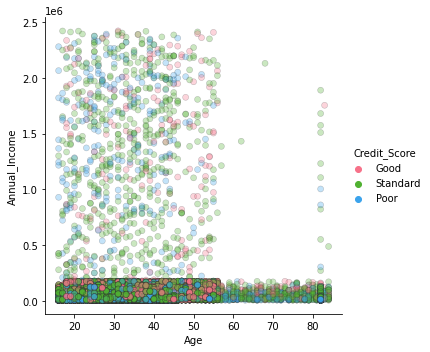

In [ ]:
sns.relplot(x = 'Age', y = 'Annual_Income' ,hue = 'Credit_Score', data = data_train,alpha=.3, edgecolor=".2", linewidth=.5,palette = 'husl')

<Figure size 720x864 with 0 Axes>

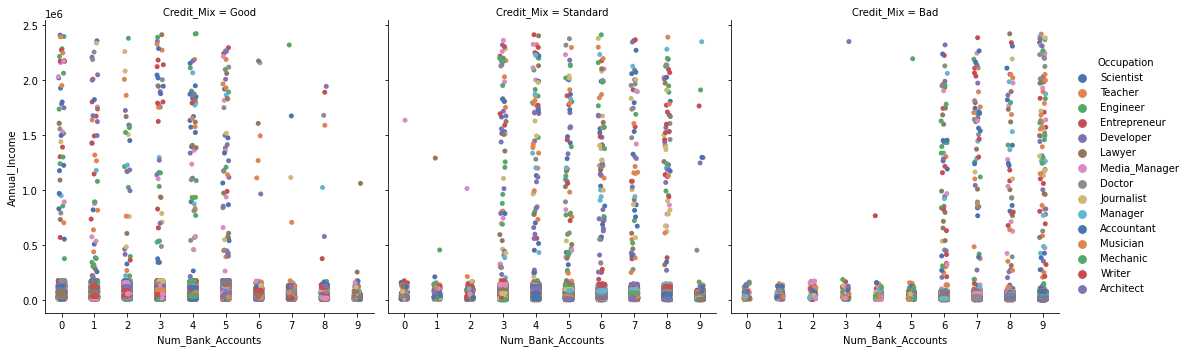

In [ ]:
plt.figure(figsize=(10,12))
sns.catplot(data=data_train, x="Num_Bank_Accounts", y="Annual_Income", hue="Occupation",col = 'Credit_Mix', palette="deep")

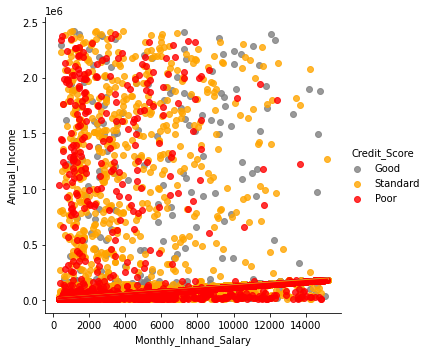

In [ ]:
g = sns.lmplot(
    data=data_train,
    x="Monthly_Inhand_Salary", y="Annual_Income", hue="Credit_Score",
    height=5,palette= ['Grey','Orange','r'])

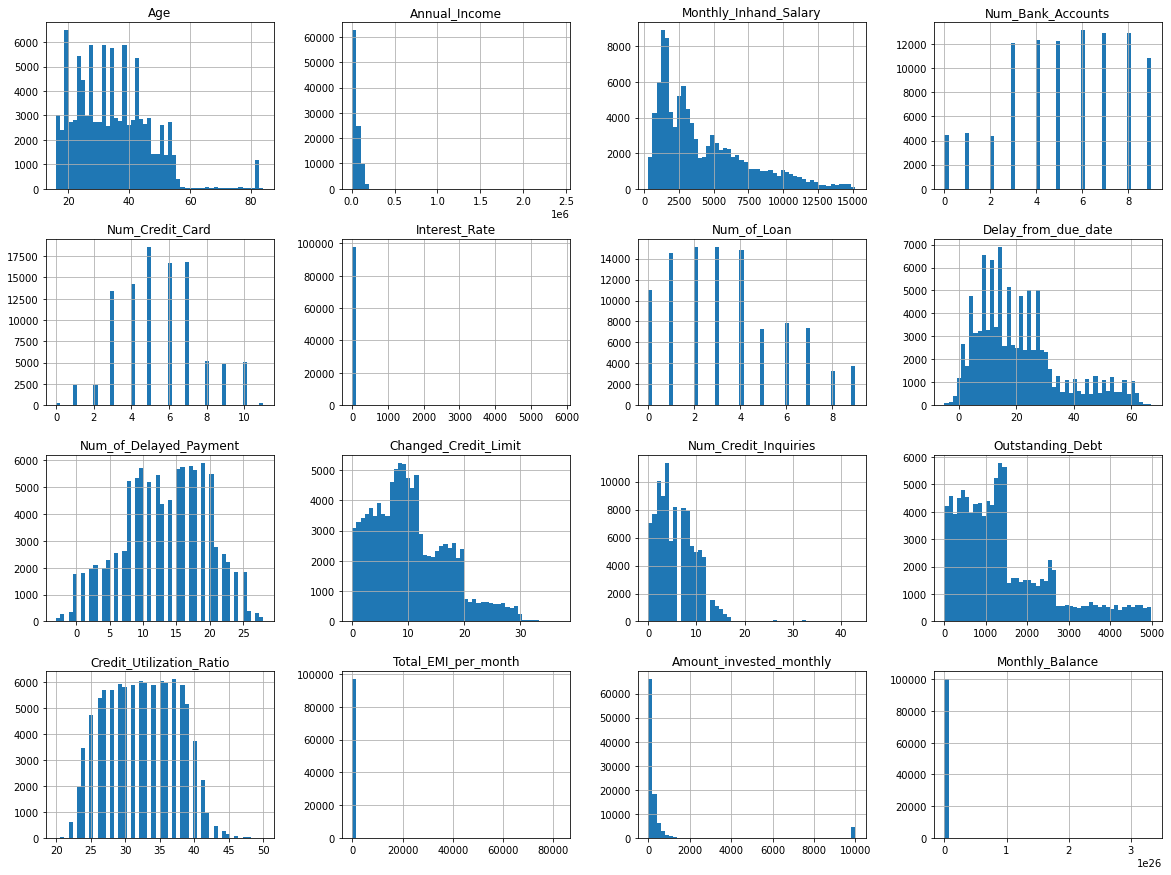

In [ ]:
data_train.hist(bins=50, figsize=(20,15))
plt.show()

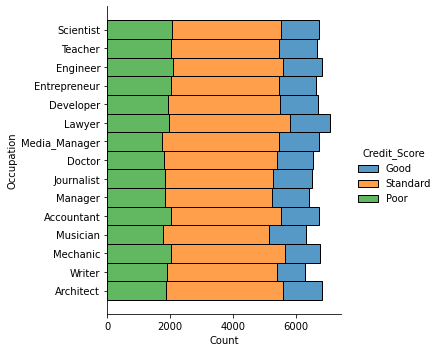

In [ ]:
sns.displot(data=data_train, y="Occupation", hue="Credit_Score", multiple="stack")

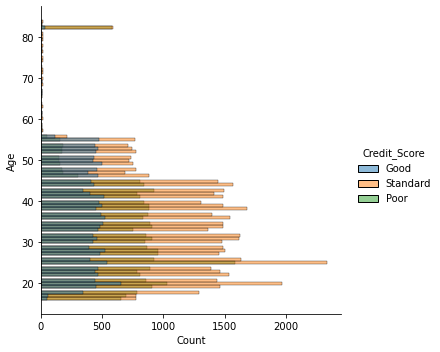

In [ ]:
sns.displot(data=data_train, y="Age", hue="Credit_Score")

<Figure size 720x864 with 0 Axes>

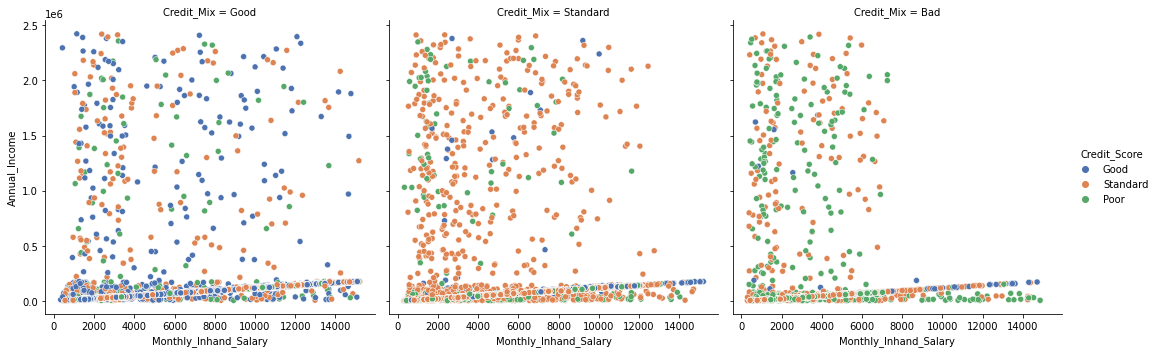

In [ ]:
plt.figure(figsize=(10,12))
sns.relplot(data=data_train, x="Monthly_Inhand_Salary", y="Annual_Income", hue="Credit_Score",col = 'Credit_Mix', palette="deep")

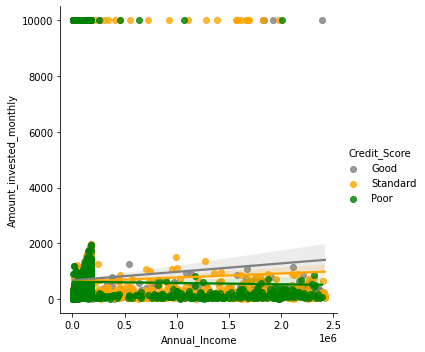

In [ ]:
g = sns.lmplot(
    data=data_train,
    y="Amount_invested_monthly", x="Annual_Income", hue="Credit_Score",
    height=5,palette= ['Grey','Orange','g'])

<Figure size 720x864 with 0 Axes>

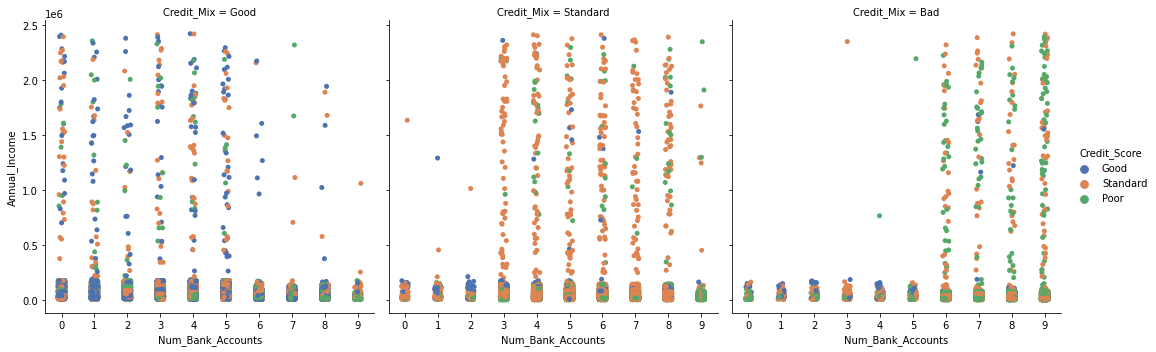

In [ ]:
plt.figure(figsize=(10,12))
sns.catplot(data=data_train, x="Num_Bank_Accounts", y="Annual_Income", hue="Credit_Score",col = 'Credit_Mix', palette="deep")

<Figure size 720x864 with 0 Axes>

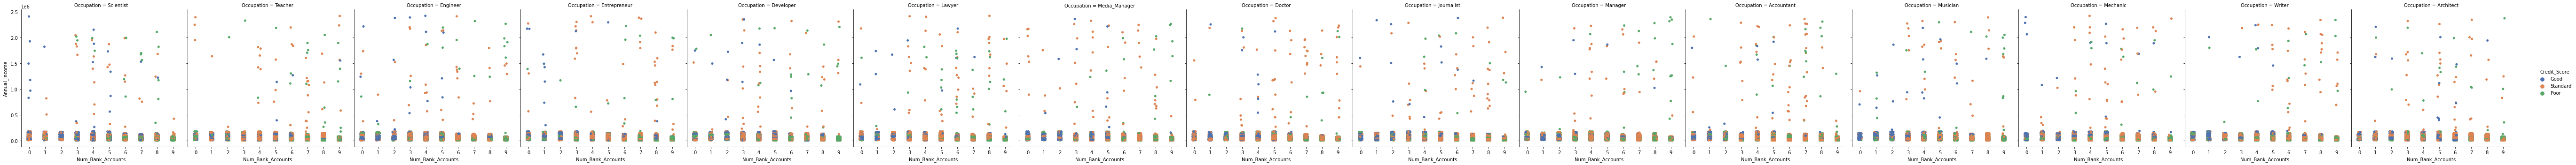

In [ ]:
plt.figure(figsize=(10,12))
sns.catplot(data=data_train, x="Num_Bank_Accounts", y="Annual_Income", hue="Credit_Score",col = 'Occupation', palette="deep")

In [ ]:
import plotly.express as px
fig = px.sunburst(data_train, path=['Credit_Score', 'Occupation'], values='Annual_Income')
fig.show()

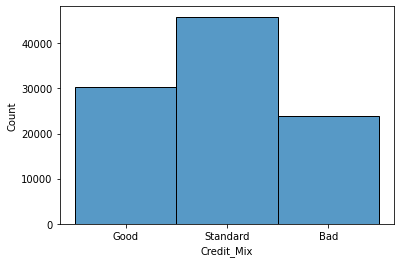

In [ ]:
sns.histplot(data=data_train, x="Credit_Mix")

Text(0.5, 1.0, 'Relation between the incomes and number of bank due to credit Mix')

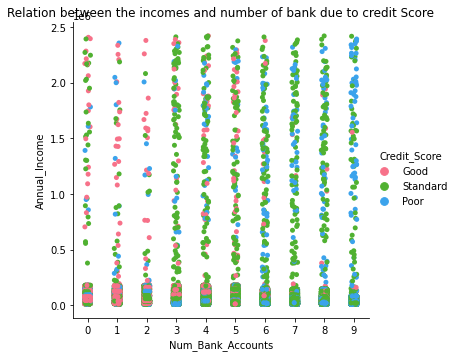

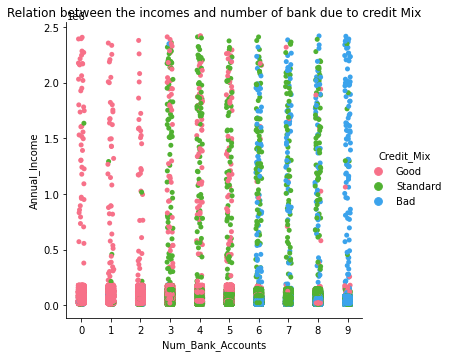

In [ ]:
sns.catplot(x = 'Num_Bank_Accounts', y = 'Annual_Income' ,hue = 'Credit_Score', data = data_train,palette = 'husl')
plt.title('Relation between the incomes and number of bank due to credit Score')

sns.catplot(x = 'Num_Bank_Accounts', y = 'Annual_Income' ,hue = 'Credit_Mix', data = data_train,palette = 'husl')
plt.title('Relation between the incomes and number of bank due to credit Mix')

Text(0.5, 1.0, 'Evolution of the credit history with annual income due to credit score')

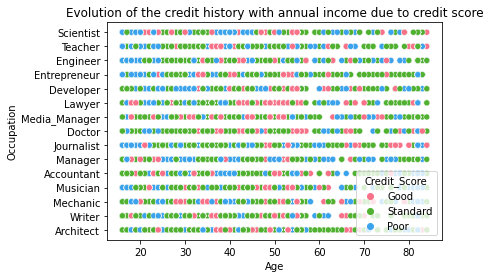

In [ ]:
sns.scatterplot(y = 'Occupation', x = 'Age' ,hue = 'Credit_Score', data = data_train,palette = 'husl')
plt.title('Evolution of the credit history with annual income due to credit score')

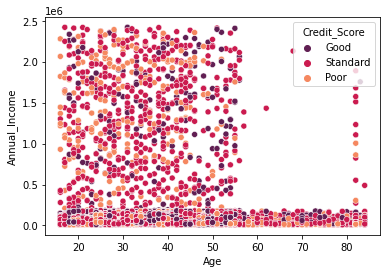

In [ ]:
sns.scatterplot(x='Age', y='Annual_Income', hue='Credit_Score' ,data = data_train,palette='rocket')

Text(0.5, 1.0, 'Influence of the loans due to Interest rate')

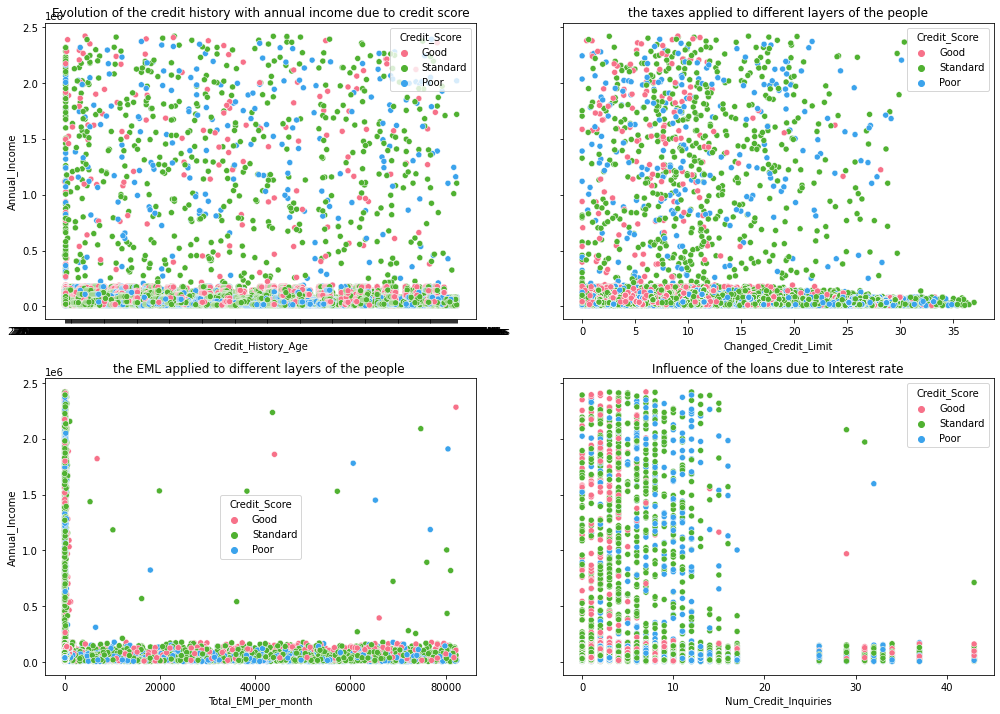

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(17, 12), sharey=True)

sns.scatterplot(x = 'Credit_History_Age', y = 'Annual_Income' ,hue = 'Credit_Score', data = data_train,palette = 'husl',ax = axes[0,0])
axes[0,0].set_title('Evolution of the credit history with annual income due to credit score')

sns.scatterplot(x='Changed_Credit_Limit',y=  'Annual_Income' ,hue = 'Credit_Score', data = data_train,palette = 'husl',ax = axes[0,1])
axes[0,1].set_title('the taxes applied to different layers of the people')

sns.scatterplot(x = 'Total_EMI_per_month', y = 'Annual_Income' ,hue = 'Credit_Score', data = data_train,palette = 'husl',ax = axes[1,0])
axes[1,0].set_title('the EML applied to different layers of the people ')

sns.scatterplot(x = 'Num_Credit_Inquiries', y = 'Annual_Income' ,hue = 'Credit_Score', data = data_train,palette = 'husl',ax = axes[1,1])
axes[1,1].set_title('Influence of the loans due to Interest rate')

Text(0.5, 1.0, 'Influence of the loans due to Interest rate')

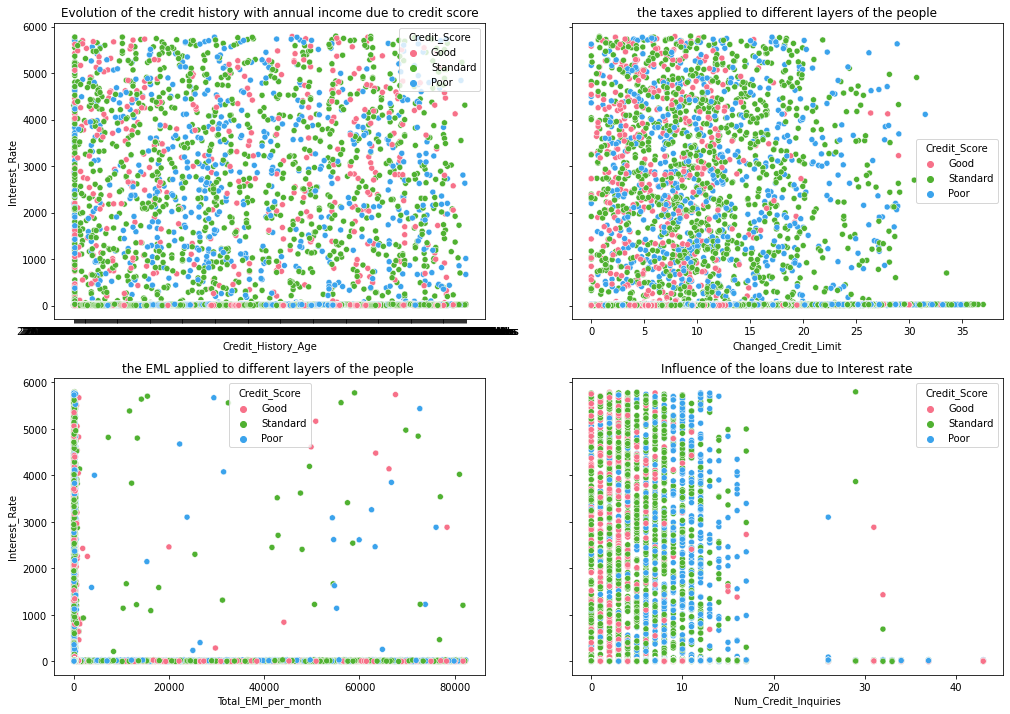

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(17, 12), sharey=True)

sns.scatterplot(x = 'Credit_History_Age', y = 'Interest_Rate' ,hue = 'Credit_Score', data = data_train,palette = 'husl',ax = axes[0,0])
axes[0,0].set_title('Evolution of the credit history with annual income due to credit score')

sns.scatterplot(x='Changed_Credit_Limit',y=  'Interest_Rate' ,hue = 'Credit_Score', data = data_train,palette = 'husl',ax = axes[0,1])
axes[0,1].set_title('the taxes applied to different layers of the people')

sns.scatterplot(x = 'Total_EMI_per_month', y = 'Interest_Rate' ,hue = 'Credit_Score', data = data_train,palette = 'husl',ax = axes[1,0])
axes[1,0].set_title('the EML applied to different layers of the people ')

sns.scatterplot(x = 'Num_Credit_Inquiries', y = 'Interest_Rate' ,hue = 'Credit_Score', data = data_train,palette = 'husl',ax = axes[1,1])
axes[1,1].set_title('Influence of the loans due to Interest rate')

Text(0.5, 1.0, 'Influence of the loans due to Interest rate')

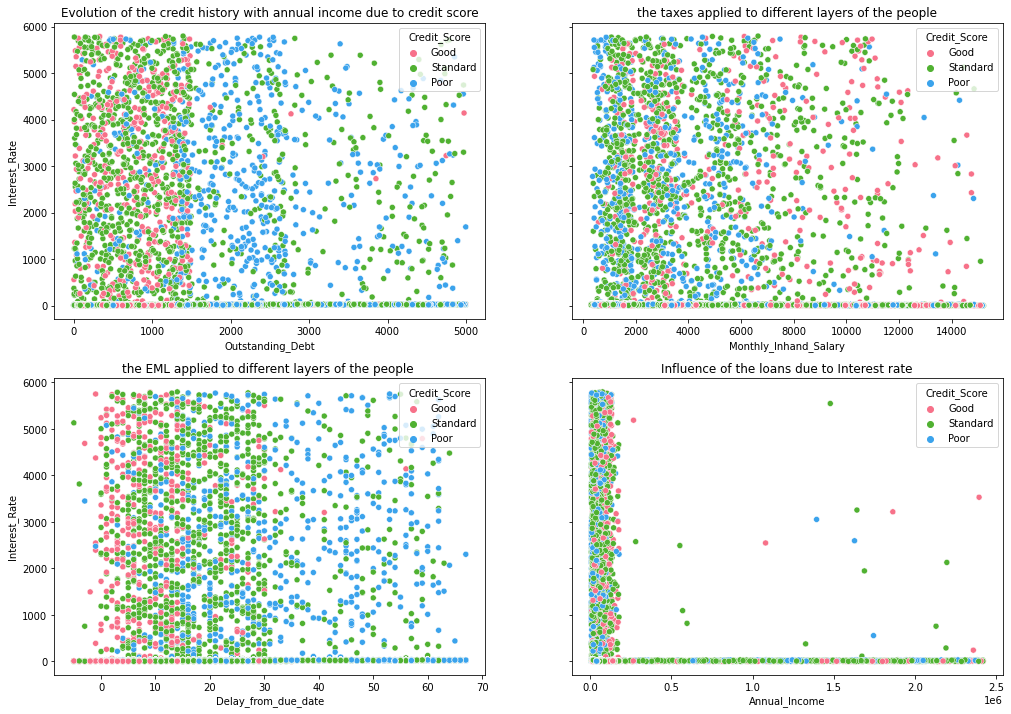

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(17, 12), sharey=True)

sns.scatterplot(x = 'Outstanding_Debt', y = 'Interest_Rate' ,hue = 'Credit_Score', data = data_train,palette = 'husl',ax = axes[0,0])
axes[0,0].set_title('Evolution of the credit history with annual income due to credit score')

sns.scatterplot(x='Monthly_Inhand_Salary',y=  'Interest_Rate' ,hue = 'Credit_Score', data = data_train,palette = 'husl',ax = axes[0,1])
axes[0,1].set_title('the taxes applied to different layers of the people')

sns.scatterplot(x = 'Delay_from_due_date', y = 'Interest_Rate' ,hue = 'Credit_Score', data = data_train,palette = 'husl',ax = axes[1,0])
axes[1,0].set_title('the EML applied to different layers of the people ')

sns.scatterplot(x = 'Annual_Income', y = 'Interest_Rate' ,hue = 'Credit_Score', data = data_train,palette = 'husl',ax = axes[1,1])
axes[1,1].set_title('Influence of the loans due to Interest rate')

Text(0.5, 1.0, 'Influence of the loans due to Interest rate')

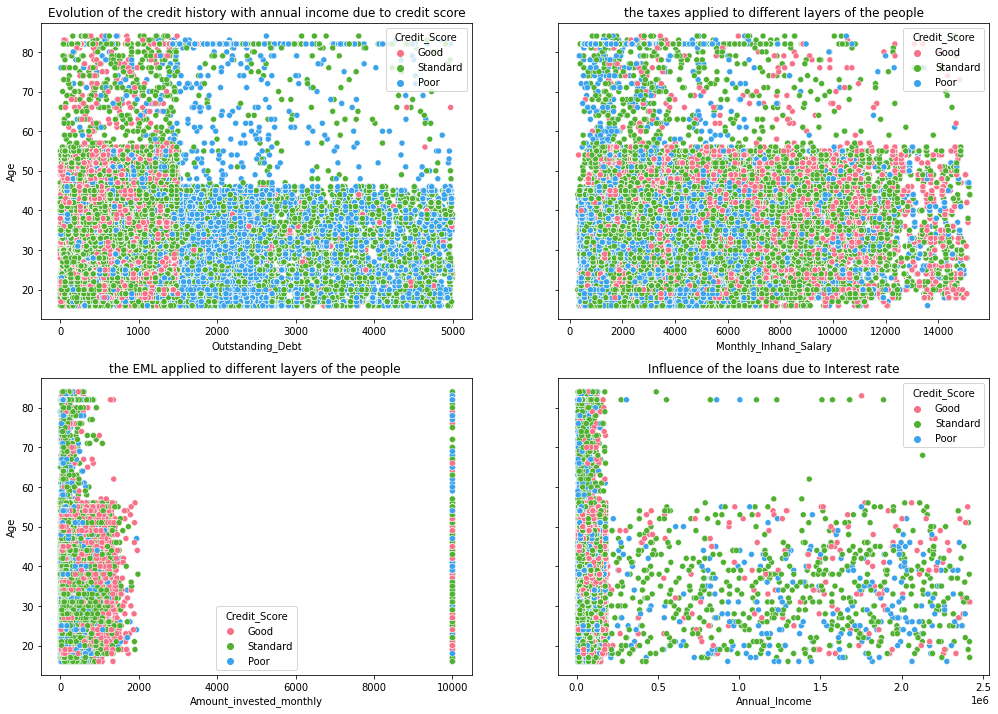

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(17, 12), sharey=True)

sns.scatterplot(x = 'Outstanding_Debt', y = 'Age' ,hue = 'Credit_Score', data = data_train,palette = 'husl',ax = axes[0,0])
axes[0,0].set_title('Evolution of the credit history with annual income due to credit score')

sns.scatterplot(x='Monthly_Inhand_Salary',y=  'Age' ,hue = 'Credit_Score', data = data_train,palette = 'husl',ax = axes[0,1])
axes[0,1].set_title('the taxes applied to different layers of the people')

sns.scatterplot(x = 'Amount_invested_monthly', y = 'Age' ,hue = 'Credit_Score', data = data_train,palette = 'husl',ax = axes[1,0])
axes[1,0].set_title('the EML applied to different layers of the people ')

sns.scatterplot(x = 'Annual_Income', y = 'Age' ,hue = 'Credit_Score', data = data_train,palette = 'husl',ax = axes[1,1])
axes[1,1].set_title('Influence of the loans due to Interest rate')

Text(0.5, 1.0, 'Influence of the loans due to Interest rate')

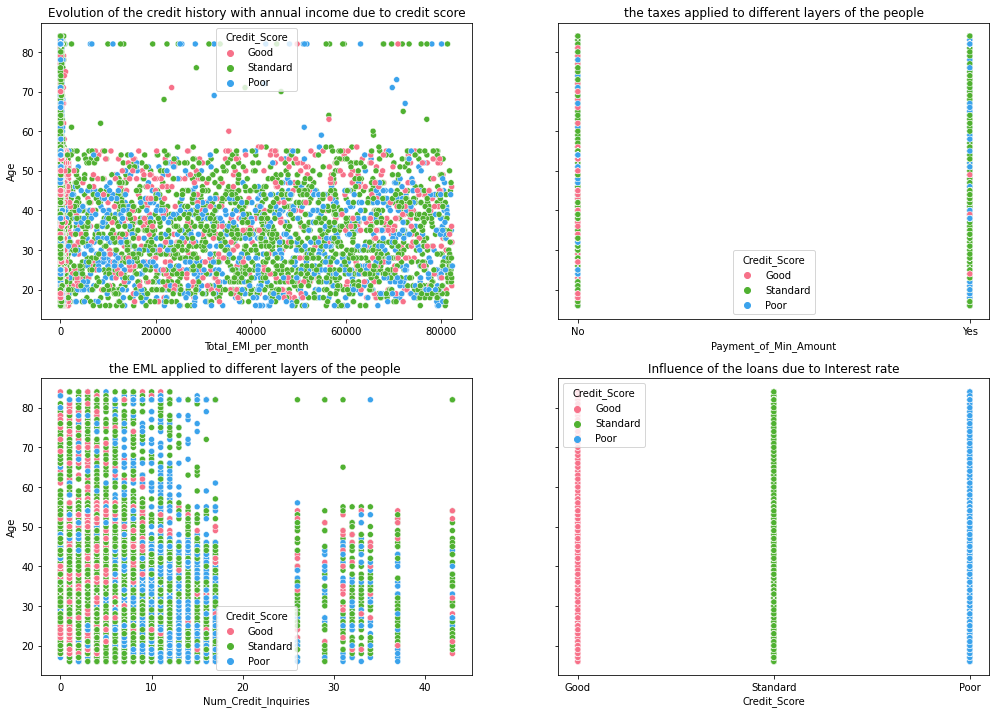

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(17, 12), sharey=True)

sns.scatterplot(x = 'Total_EMI_per_month', y = 'Age' ,hue = 'Credit_Score', data = data_train,palette = 'husl',ax = axes[0,0])
axes[0,0].set_title('Evolution of the credit history with annual income due to credit score')

sns.scatterplot(x='Payment_of_Min_Amount',y=  'Age' ,hue = 'Credit_Score', data = data_train,palette = 'husl',ax = axes[0,1])
axes[0,1].set_title('the taxes applied to different layers of the people')

sns.scatterplot(x = 'Num_Credit_Inquiries', y = 'Age' ,hue = 'Credit_Score', data = data_train,palette = 'husl',ax = axes[1,0])
axes[1,0].set_title('the EML applied to different layers of the people ')

sns.scatterplot(x = 'Credit_Score', y = 'Age' ,hue = 'Credit_Score', data = data_train,palette = 'husl',ax = axes[1,1])
axes[1,1].set_title('Influence of the loans due to Interest rate')

Text(0.5, 1.0, 'Influence of the loans due to Interest rate')

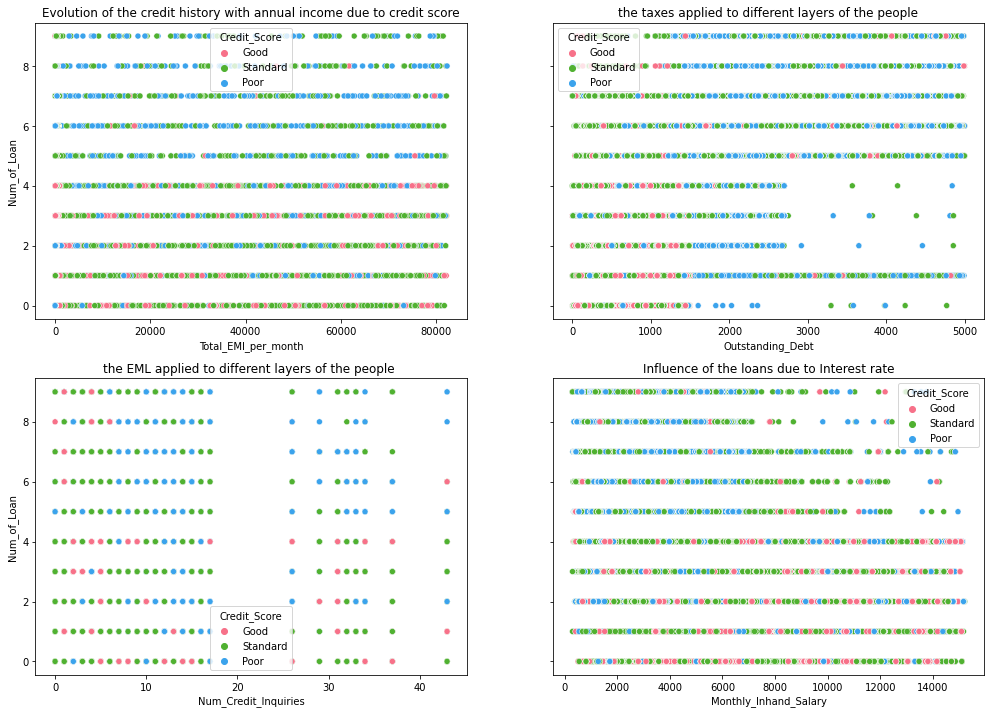

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(17, 12), sharey=True)

sns.scatterplot(x = 'Total_EMI_per_month', y = 'Num_of_Loan' ,hue = 'Credit_Score', data = data_train,palette = 'husl',ax = axes[0,0])
axes[0,0].set_title('Evolution of the credit history with annual income due to credit score')

sns.scatterplot(x='Outstanding_Debt',y=  'Num_of_Loan' ,hue = 'Credit_Score', data = data_train,palette = 'husl',ax = axes[0,1])
axes[0,1].set_title('the taxes applied to different layers of the people')

sns.scatterplot(x = 'Num_Credit_Inquiries', y = 'Num_of_Loan' ,hue = 'Credit_Score', data = data_train,palette = 'husl',ax = axes[1,0])
axes[1,0].set_title('the EML applied to different layers of the people ')

sns.scatterplot(x = 'Monthly_Inhand_Salary', y = 'Num_of_Loan' ,hue = 'Credit_Score', data = data_train,palette = 'husl',ax = axes[1,1])
axes[1,1].set_title('Influence of the loans due to Interest rate')

Text(0.5, 1.0, 'Influence of the loans due to Interest rate')

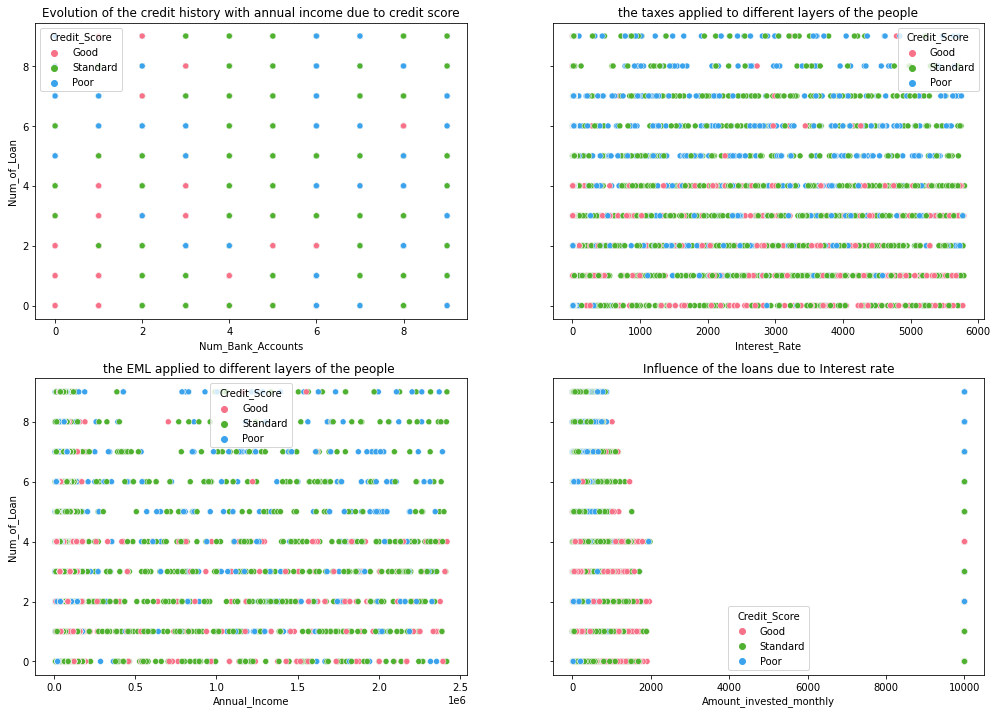

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(17, 12), sharey=True)

sns.scatterplot(x = 'Num_Bank_Accounts', y = 'Num_of_Loan' ,hue = 'Credit_Score', data = data_train,palette = 'husl',ax = axes[0,0])
axes[0,0].set_title('Evolution of the credit history with annual income due to credit score')

sns.scatterplot(x='Interest_Rate',y=  'Num_of_Loan' ,hue = 'Credit_Score', data = data_train,palette = 'husl',ax = axes[0,1])
axes[0,1].set_title('the taxes applied to different layers of the people')

sns.scatterplot(x = 'Annual_Income', y = 'Num_of_Loan' ,hue = 'Credit_Score', data = data_train,palette = 'husl',ax = axes[1,0])
axes[1,0].set_title('the EML applied to different layers of the people ')

sns.scatterplot(x = 'Amount_invested_monthly', y = 'Num_of_Loan' ,hue = 'Credit_Score', data = data_train,palette = 'husl',ax = axes[1,1])
axes[1,1].set_title('Influence of the loans due to Interest rate')

In [ ]:
plt.figure(figsize=(42,40))
sns.pairplot(data_train, hue="Credit_Score",corner=True)

Output hidden; open in https://colab.research.google.com to view.

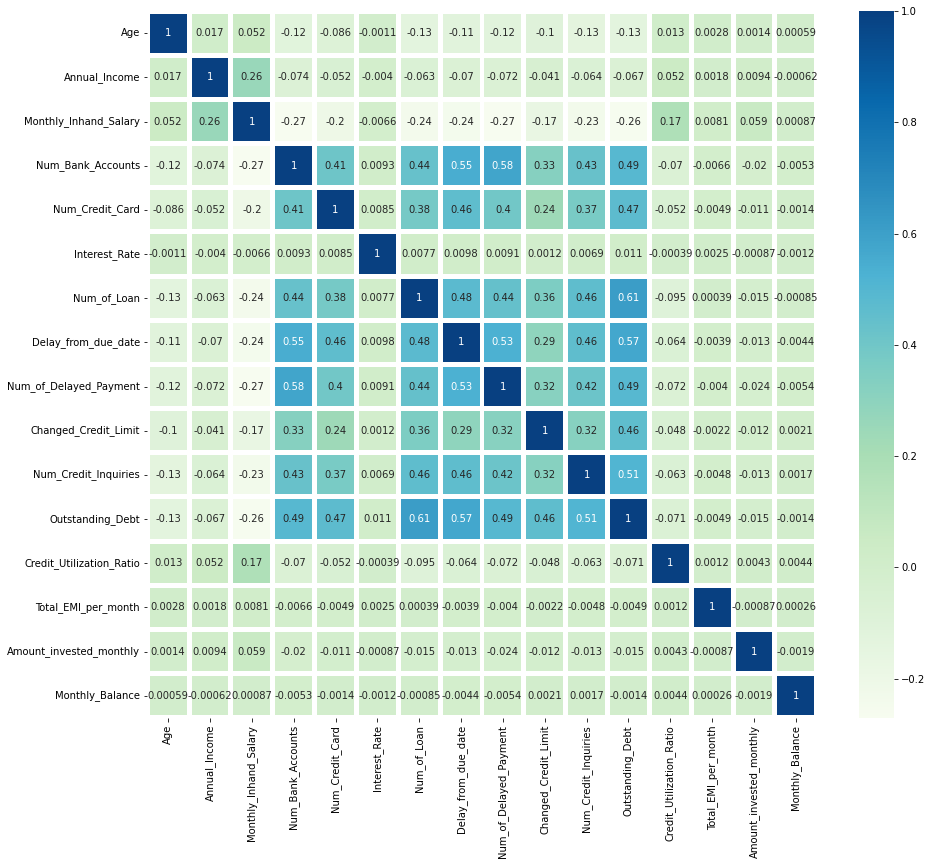

In [ ]:
plt.figure(figsize=(15,13))
sns.heatmap(data_train.corr(),cbar = True,cmap = 'GnBu', annot =True, linewidths=4, linecolor='white')

#### Detecting and cleaning outliers

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



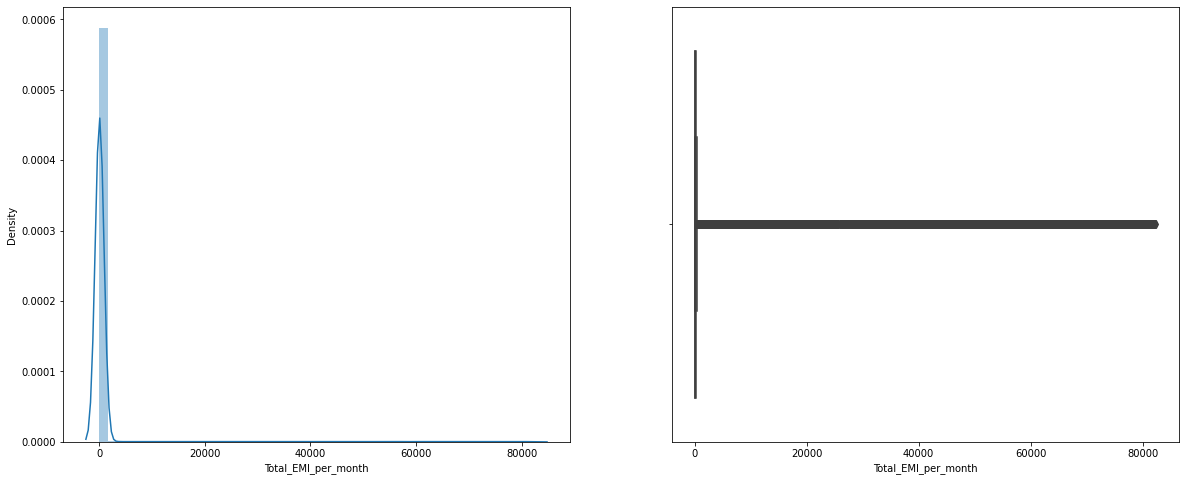

In [ ]:
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
sns.distplot(data_train['Total_EMI_per_month'])
plt.subplot(1,2,2)
sns.boxplot(data_train['Total_EMI_per_month'])

In [ ]:
percentile25 = data_train['Total_EMI_per_month'].quantile(0.25)
percentile75 = data_train['Total_EMI_per_month'].quantile(0.75)
iqr = percentile75 - percentile25
upper_limit = percentile75 + 1.5 * iqr
lower_limit = percentile25 - 1.5 * iqr

In [ ]:
data_train = data_train[(data_train['Total_EMI_per_month']>lower_limit) & (data_train['Total_EMI_per_month']<upper_limit)]
data_train = data_train.dropna()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



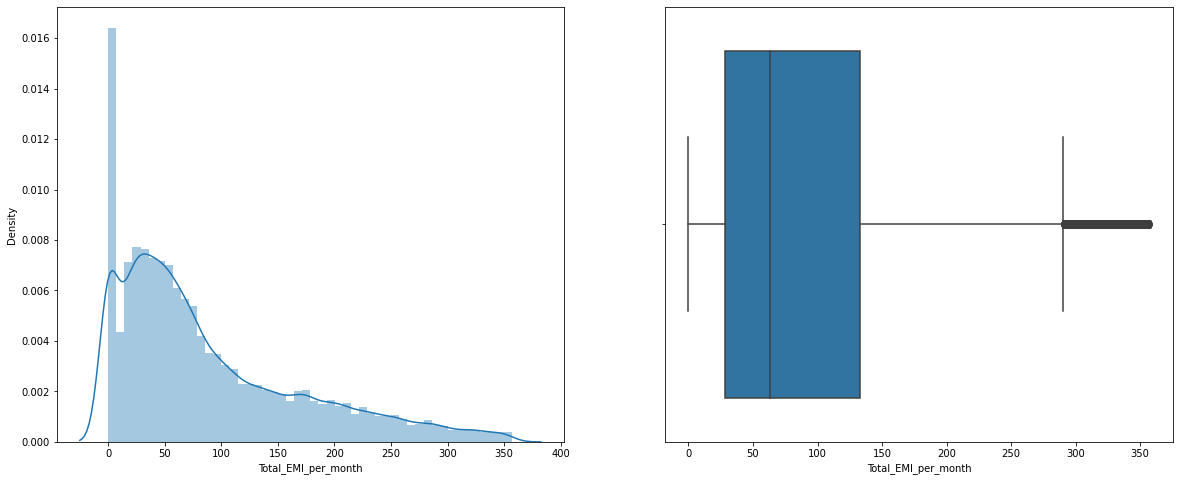

In [ ]:
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
sns.distplot(data_train['Total_EMI_per_month'])
plt.subplot(1,2,2)
sns.boxplot(data_train['Total_EMI_per_month'])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



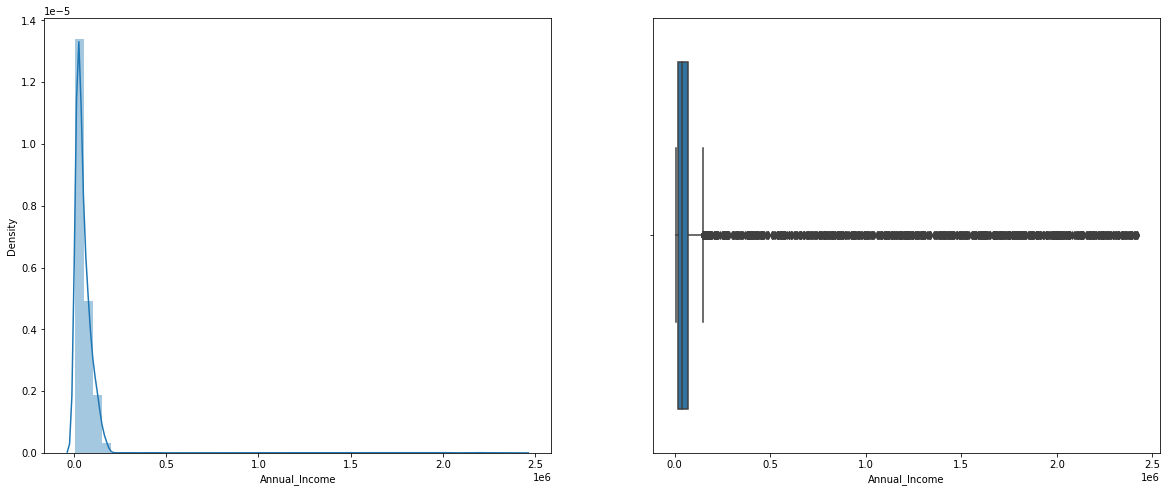

In [ ]:
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
sns.distplot(data_train['Annual_Income'])
plt.subplot(1,2,2)
sns.boxplot(data_train['Annual_Income'])

In [ ]:
percentile25 = data_train['Annual_Income'].quantile(0.25)
percentile75 = data_train['Annual_Income'].quantile(0.75)
iqr = percentile75 - percentile25
upper_limit = percentile75 + 1.5 * iqr
lower_limit = percentile25 - 1.5 * iqr

In [ ]:
data_train = data_train[(data_train['Annual_Income']>lower_limit) & (data_train['Annual_Income']<upper_limit)]
data_train = data_train.dropna()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



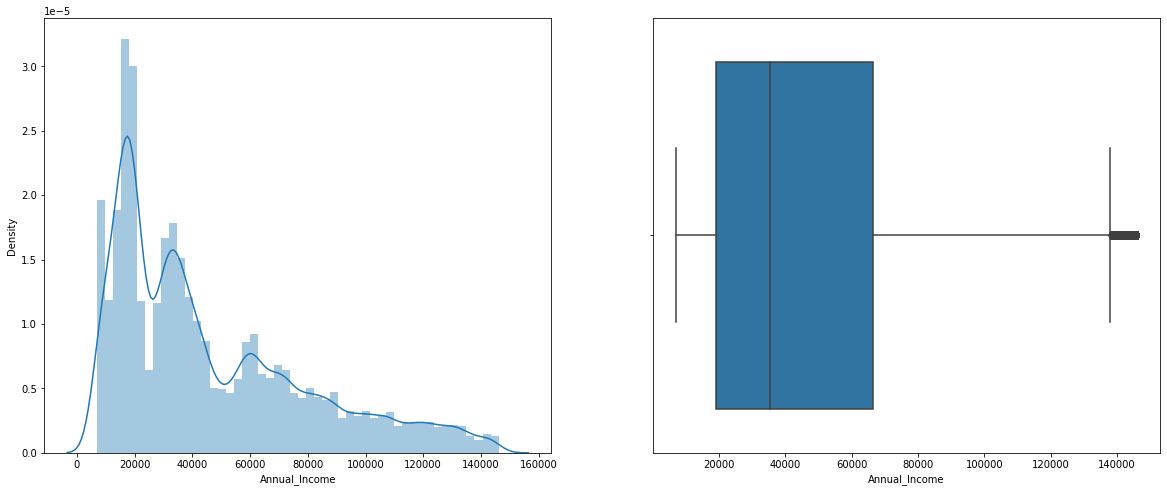

In [ ]:
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
sns.distplot(data_train['Annual_Income'])
plt.subplot(1,2,2)
sns.boxplot(data_train['Annual_Income'])

In [ ]:
data_train.shape

(90493, 27)

### Data Preprocessing

In [ ]:
data_train.drop(['Customer_ID','Name','SSN'] ,axis= 1 , inplace = True)#Remove Unnesessary Columns

In [ ]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
for column in data_train.columns:
  if data_train[column].dtypes == 'object':
    data_train[column] = ordinal_encoder.fit_transform(data_train[[column]])


# from sklearn.preprocessing import OrdinalEncoder
# ordinal_encoder = OrdinalEncoder()
# for column in data_test.columns:
#   # if data_test[column].dtypes == 'object':
#     data_test[column] = ordinal_encoder.fit_transform(data_test[[column]])

In [ ]:
X = data_train.copy()
y = X.pop("Credit_Score")

# Label encoding for categoricals
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()

discrete_features = X.dtypes == int

from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y, discrete_features)

Annual_Income               0.625966
Outstanding_Debt            0.615416
Monthly_Inhand_Salary       0.596656
Total_EMI_per_month         0.562226
Type_of_Loan                0.331642
Interest_Rate               0.186048
Credit_Mix                  0.180979
Delay_from_due_date         0.124056
Payment_of_Min_Amount       0.112366
Num_Credit_Inquiries        0.106108
Changed_Credit_Limit        0.105347
Num_Bank_Accounts           0.100983
Num_Credit_Card             0.098496
Credit_History_Age          0.093406
Num_of_Delayed_Payment      0.083630
Num_of_Loan                 0.082472
Age                         0.027605
Amount_invested_monthly     0.017639
Payment_Behaviour           0.005313
Credit_Utilization_Ratio    0.002621
Occupation                  0.001439
Month                       0.000000
Monthly_Balance             0.000000
Name: MI Scores, dtype: float64


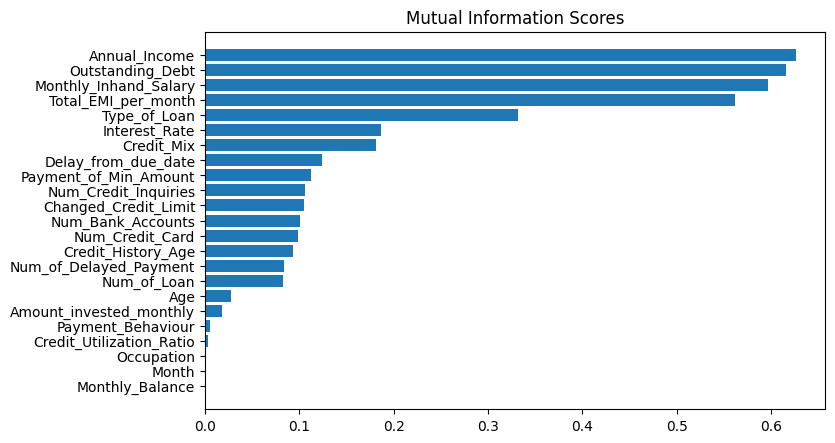

In [ ]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

print(mi_scores)
plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

In [ ]:
data_train.drop(['Month','Monthly_Balance',
                'Occupation','Credit_Utilization_Ratio',
                 'Payment_Behaviour'] ,axis= 1 , inplace = True) #Remove Unnesessary Columns, detected by mutual information score

In [ ]:
data_train.Annual_Income = (data_train.Annual_Income - data_train.Annual_Income.mean())/data_train.Annual_Income.std()
data_train.Monthly_Inhand_Salary = (data_train.Monthly_Inhand_Salary - data_train.Monthly_Inhand_Salary.mean())/data_train.Monthly_Inhand_Salary.std()
data_train.Type_of_Loan = (data_train.Type_of_Loan - data_train.Type_of_Loan.mean())/data_train.Type_of_Loan.std()
data_train.Outstanding_Debt = (data_train.Outstanding_Debt - data_train.Outstanding_Debt.mean())/data_train.Outstanding_Debt.std()
data_train.Credit_History_Age = (data_train.Credit_History_Age - data_train.Credit_History_Age.mean())/data_train.Credit_History_Age.std()
data_train.Total_EMI_per_month = (data_train.Total_EMI_per_month - data_train.Total_EMI_per_month.mean())/data_train.Total_EMI_per_month.std()
data_train.Amount_invested_monthly = (data_train.Amount_invested_monthly - data_train.Amount_invested_monthly.mean())/data_train.Amount_invested_monthly.std()

In [ ]:
data_train.head(5)

Age  Annual_Income  Monthly_Inhand_Salary  Num_Bank_Accounts  \
0   23      -0.808872              -0.723507                  3   
1   23      -0.808872              -0.723507                  3   
2   20      -0.808872              -0.723507                  3   
3   23      -0.808872              -0.723507                  3   
4   23      -0.808872              -0.723507                  3   

   Num_Credit_Card  Interest_Rate  Num_of_Loan  Type_of_Loan  \
0                4              3            4     -1.663164   
1                4              3            4     -1.663164   
2                4              3            4     -1.663164   
3                4              3            4     -1.663164   
4                4              3            4     -1.663164   

   Delay_from_due_date  Num_of_Delayed_Payment  Changed_Credit_Limit  \
0                    3                     7.0                 11.27   
1                   -1                     7.0                 11.27   
2                    3                     7.0                 11.27   
3                    5                     4.0                  6.27   
4                    6                     4.0                 11.27   

   Num_Credit_Inquiries  Credit_Mix  Outstanding_Debt  Credit_History_Age  \
0                   4.0         1.0         -0.540859           -0.284349   
1                   4.0         1.0         -0.540859            1.560886   
2                   4.0         1.0         -0.540859           -0.251398   
3                   4.0         1.0         -0.540859           -0.243160   
4                   4.0         1.0         -0.540859           -0.234923   

   Payment_of_Min_Amount  Total_EMI_per_month  Amount_invested_monthly  \
0                    0.0            -0.478699                -0.266293   
1                    0.0            -0.478699                -0.247778   
2                    0.0            -0.478699                -0.265665   
3                    0.0            -0.478699                -0.208084   
4                    0.0            -0.478699                -0.285361   

   Credit_Score  
0           0.0  
1           0.0  
2           0.0  
3           0.0  
4           0.0

In [ ]:
x = data_train.drop('Credit_Score',axis=1)
y = data_train['Credit_Score']
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.1, random_state=25)
print(x_train.shape,x_test.shape,y_train.shape,y_test.shape)

(81443, 18) (9050, 18) (81443,) (9050,)


<b> Training and Evaluating the model

In [ ]:
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import precision_score, accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier as knn

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE

              precision    recall  f1-score   support

         0.0       0.50      0.24      0.32      1521
         1.0       0.62      0.48      0.54      2706
         2.0       0.61      0.79      0.69      4823

    accuracy                           0.61      9050
   macro avg       0.58      0.50      0.52      9050
weighted avg       0.60      0.61      0.58      9050



/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



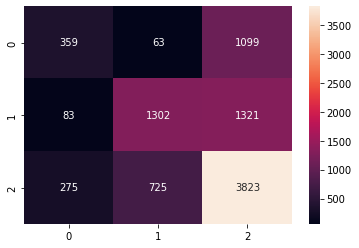

In [ ]:
logre = LogisticRegression()
logre.fit(x_train, y_train)


prediction = logre.predict(x_test)

print(classification_report(y_test, prediction))
conf = confusion_matrix(y_test, prediction)
sns.heatmap(conf , annot = True, fmt = 'd')

In [ ]:
ETC_Updated= ExtraTreesClassifier(n_estimators = 10,bootstrap = True)
ETC_Updated.fit(x_train, y_train)

ExtraTreesClassifier(bootstrap=True, n_estimators=10)

In [ ]:
print(ETC_Updated.score(x_train,y_train))
ETC_Updated.score(x_test,y_test)

0.9852534901710399


0.7986740331491713

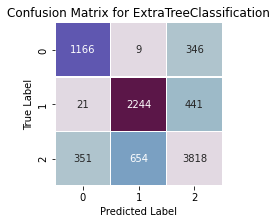

In [ ]:
# Plot confusion matrix for ExtraTreeClassifier.
matrix = confusion_matrix(y_test,ETC_Updated.predict(x_test))
plt.figure(figsize=(3,3))
sns.heatmap(matrix,annot=True, cbar=False, cmap='twilight',linewidth=0.5,fmt="d")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix for ExtraTreeClassification');

In [ ]:
print('\n clasification report:\n', classification_report(y_test,ETC_Updated.predict(x_test)))


 clasification report:
               precision    recall  f1-score   support

         0.0       0.76      0.77      0.76      1521
         1.0       0.77      0.83      0.80      2706
         2.0       0.83      0.79      0.81      4823

    accuracy                           0.80      9050
   macro avg       0.79      0.80      0.79      9050
weighted avg       0.80      0.80      0.80      9050



#### Using SMOTE to balance the data

In [ ]:
SMT = SMOTE()
x_SMT, y_SMT = SMT.fit_resample(x,y)
x_train_smote, x_test_smote, y_train_smote, y_test_smote = train_test_split(x_SMT, y_SMT, test_size=0.15, random_state=42)

In [ ]:
print(x_train_smote.shape,x_test_smote.shape,y_train_smote.shape,y_test_smote.shape)

(123901, 18) (21866, 18) (123901,) (21866,)


In [ ]:
ETC_Mod= ExtraTreesClassifier(n_estimators = 10,bootstrap = True)
ETC_Mod.fit(x_train_smote, y_train_smote)

ExtraTreesClassifier(bootstrap=True, n_estimators=10)

In [ ]:
print(ETC_Mod.score(x_train_smote,y_train_smote))
y_pred = ETC_Mod.predict(x_test_smote)
accuracy_score(y_test_smote,y_pred)

0.9892091266414315


0.8661392115613281

In [ ]:
print(ETC_Mod.score(x_train_smote,y_train_smote))
y_pred = ETC_Mod.predict(x_test)
accuracy_score(y_test,y_pred)

0.9892091266414315


0.9624309392265193

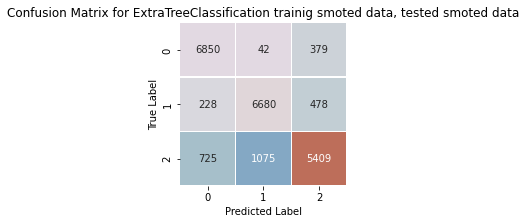

In [ ]:
matrix = confusion_matrix(y_test_smote,ETC_Mod.predict(x_test_smote))
plt.figure(figsize=(3,3))
sns.heatmap(matrix,annot=True, cbar=False, cmap='twilight',linewidth=0.5,fmt="d")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix for ExtraTreeClassification trainig smoted data, tested smoted data');

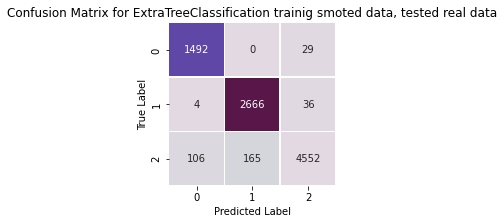

In [ ]:
# Plot confusion matrix for ExtraTreeClassifier.
matrix = confusion_matrix(y_test,ETC_Mod.predict(x_test))
plt.figure(figsize=(3,3))
sns.heatmap(matrix,annot=True, cbar=False, cmap='twilight',linewidth=0.5,fmt="d")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix for ExtraTreeClassification trainig smoted data, tested real data');

In [ ]:
print('\n clasification report:\n', classification_report(y_test_smote,ETC_Mod.predict(x_test_smote)))


 clasification report:
               precision    recall  f1-score   support

         0.0       0.88      0.94      0.91      7271
         1.0       0.86      0.90      0.88      7386
         2.0       0.86      0.75      0.80      7209

    accuracy                           0.87     21866
   macro avg       0.87      0.87      0.86     21866
weighted avg       0.87      0.87      0.86     21866



In [ ]:
print('\n clasification report:\n', classification_report(y_test,ETC_Mod.predict(x_test)))


 clasification report:
               precision    recall  f1-score   support

         0.0       0.93      0.98      0.96      1521
         1.0       0.94      0.99      0.96      2706
         2.0       0.99      0.94      0.96      4823

    accuracy                           0.96      9050
   macro avg       0.95      0.97      0.96      9050
weighted avg       0.96      0.96      0.96      9050



### Other models

In [ ]:
import missingno
from collections import Counter
from collections import OrderedDict


### Dictionary to store model and its accuracy

model_accuracy = OrderedDict()
### Dictionary to store model and its precision

model_precision = OrderedDict()
### Dictionary to store model and its recall

model_recall = OrderedDict()

In [ ]:
### Training the Logistic Regression model on the dataset

logistic_classifier = LogisticRegression(random_state = 27)
logistic_classifier.fit(x_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



LogisticRegression(random_state=27)

In [ ]:
### Predicting the Test set results

Y_pred = logistic_classifier.predict(x_test)


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score

### Making the confusion matrix

cm = confusion_matrix(y_test, Y_pred)
print(cm)

### Printing the accuracy, precision, and recall of the model

logistic_accuracy = round(100 * accuracy_score(y_test, Y_pred), 2)
model_accuracy['Logistic Regression'] = logistic_accuracy

logistic_precision = round(100 * precision_score(y_test, Y_pred, average = 'weighted'), 2)
model_precision['Logistic Regression'] = logistic_precision

logistic_recall = round(100 * recall_score(y_test, Y_pred, average = 'weighted'), 2)
model_recall['Logistic Regression'] = logistic_recall

print('The accuracy of this model is {} %.'.format(logistic_accuracy))
print('The precision of this model is {} %.'.format(logistic_precision))
print('The recall of this model is {} %.'.format(logistic_recall))

[[ 359   63 1099]
 [  83 1302 1321]
 [ 275  725 3823]]
The accuracy of this model is 60.6 %.
The precision of this model is 59.68 %.
The recall of this model is 60.6 %.


In [ ]:
### Applying KNN with k=1 model

classifier_1nn = KNeighborsClassifier(n_neighbors = 1, algorithm = 'auto', p = 2, metric = 'minkowski')
classifier_1nn.fit(x_train, y_train)

KNeighborsClassifier(n_neighbors=1)

In [ ]:
### Predicting the Test set results

Y_pred = classifier_1nn.predict(x_test)


In [ ]:
### Making the confusion matrix

cm = confusion_matrix(y_test, Y_pred)
print(cm)

### Printing the accuracy, precision, and recall of the model

nn1_accuracy = round(100 * accuracy_score(y_test, Y_pred), 2)
model_accuracy['1 - Nearest Neighbors'] = nn1_accuracy

nn1_precision = round(100 * precision_score(y_test, Y_pred, average = 'weighted'), 2)
model_precision['1 - Nearest Neighbors'] = nn1_precision

nn1_recall = round(100 * recall_score(y_test, Y_pred, average = 'weighted'), 2)
model_recall['1 - Nearest Neighbors'] = nn1_recall

print('The accuracy of this model is {} %.'.format(nn1_accuracy))
print('The precision of this model is {} %.'.format(nn1_precision))
print('The recall of this model is {} %.'.format(nn1_recall))

[[1047   35  439]
 [  30 1993  683]
 [ 417  665 3741]]
The accuracy of this model is 74.93 %.
The precision of this model is 74.9 %.
The recall of this model is 74.93 %.


In [ ]:
### Applying 3NN model

classifier_3nn = KNeighborsClassifier(n_neighbors = 3, algorithm = 'auto', p = 2, metric = 'minkowski')
classifier_3nn.fit(x_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [ ]:
### Predicting the Test set results

Y_pred = classifier_3nn.predict(x_test)

In [ ]:
### Making the confusion matrix

cm = confusion_matrix(y_test, Y_pred)
print(cm)

### Printing the accuracy, precision, and recall of the model

nn3_accuracy = round(100 * accuracy_score(y_test, Y_pred), 2)
model_accuracy['3 - Nearest Neighbors'] = nn3_accuracy

nn3_precision = round(100 * precision_score(y_test, Y_pred, average = 'weighted'), 2)
model_precision['3 - Nearest Neighbors'] = nn3_precision

nn3_recall = round(100 * recall_score(y_test, Y_pred, average = 'weighted'), 2)
model_recall['3 - Nearest Neighbors'] = nn3_recall

print('The accuracy of this model is {} %.'.format(nn3_accuracy))
print('The precision of this model is {} %.'.format(nn3_precision))
print('The recall of this model is {} %.'.format(nn3_recall))

[[1074   15  432]
 [  56 2099  551]
 [ 447  662 3714]]
The accuracy of this model is 76.1 %.
The precision of this model is 76.19 %.
The recall of this model is 76.1 %.


In [ ]:
### Applying 5NN model

classifier_5nn = KNeighborsClassifier(n_neighbors = 5, algorithm = 'auto', p = 2, metric = 'minkowski')
classifier_5nn.fit(x_train, y_train)

KNeighborsClassifier()

In [ ]:
### Predicting the Test set results

Y_pred = classifier_5nn.predict(x_test)

In [ ]:
### Making the confusion matrix

cm = confusion_matrix(y_test, Y_pred)
print(cm)

### Printing the accuracy, precision, and recall of the model

nn5_accuracy = round(100 * accuracy_score(y_test, Y_pred), 2)
model_accuracy['5 - Nearest Neighbors'] = nn5_accuracy

nn5_precision = round(100 * precision_score(y_test, Y_pred, average = 'weighted'), 2)
model_precision['5 - Nearest Neighbors'] = nn5_precision

nn5_recall = round(100 * recall_score(y_test, Y_pred, average = 'weighted'), 2)
model_recall['5 - Nearest Neighbors'] = nn5_recall

print('The accuracy of this model is {} %.'.format(nn5_accuracy))
print('The precision of this model is {} %.'.format(nn5_precision))
print('The recall of this model is {} %.'.format(nn5_recall))

[[1042   37  442]
 [  57 2115  534]
 [ 421  685 3717]]
The accuracy of this model is 75.96 %.
The precision of this model is 76.02 %.
The recall of this model is 75.96 %.


In [ ]:
### Applying 7NN model

classifier_7nn = KNeighborsClassifier(n_neighbors = 7, algorithm = 'auto', p = 2, metric = 'minkowski')
classifier_7nn.fit(x_train, y_train)

KNeighborsClassifier(n_neighbors=7)

In [ ]:
### Predicting the Test set results

Y_pred = classifier_7nn.predict(x_test)

In [ ]:
### Making the confusion matrix

cm = confusion_matrix(y_test, Y_pred)
print(cm)

### Printing the accuracy, precision, and recall of the model

nn7_accuracy = round(100 * accuracy_score(y_test, Y_pred), 2)
model_accuracy['7 - Nearest Neighbors'] = nn7_accuracy

nn7_precision = round(100 * precision_score(y_test, Y_pred, average = 'weighted'), 2)
model_precision['7 - Nearest Neighbors'] = nn7_precision

nn7_recall = round(100 * recall_score(y_test, Y_pred, average = 'weighted'), 2)
model_recall['7 - Nearest Neighbors'] = nn7_recall

print('The accuracy of this model is {} %.'.format(nn7_accuracy))
print('The precision of this model is {} %.'.format(nn7_precision))
print('The recall of this model is {} %.'.format(nn7_recall))

[[ 981   49  491]
 [  66 2080  560]
 [ 389  659 3775]]
The accuracy of this model is 75.54 %.
The precision of this model is 75.48 %.
The recall of this model is 75.54 %.


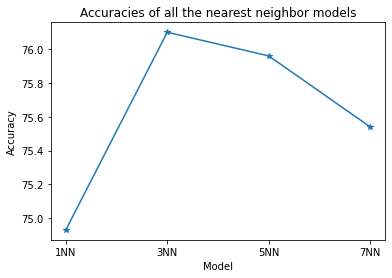

In [ ]:
### Looking at the accuracy graph of all the nearest neighbors

labels = ['1NN', '3NN', '5NN', '7NN']
values = [nn1_accuracy, nn3_accuracy, nn5_accuracy, nn7_accuracy]

plt.title('Accuracies of all the nearest neighbor models')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.plot(labels, values, '*-')
plt.show()

<b> Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import VotingClassifier

### Tabulating the results

from tabulate import tabulate

### Model Validation

from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

### Remove unnecessary warnings

import warnings
warnings.filterwarnings('ignore')

In [ ]:
### Applying Naive Bayes Classification model

naive_bayes_classifier = GaussianNB()
naive_bayes_classifier.fit(x_train, y_train)

GaussianNB()

In [ ]:
### Predicting the Test set results

Y_pred = naive_bayes_classifier.predict(x_test)

In [ ]:
### Making the confusion matrix

cm = confusion_matrix(y_test, Y_pred)
print(cm)

### Printing the accuracy, precision, and recall of the model

naive_bayes_accuracy = round(100 * accuracy_score(y_test, Y_pred), 2)
model_accuracy['Gaussian Naive Bayes'] = naive_bayes_accuracy

naive_bayes_precision = round(100 * precision_score(y_test, Y_pred, average = 'weighted'), 2)
model_precision['Gaussian Naive Bayes'] = naive_bayes_precision

naive_bayes_recall = round(100 * recall_score(y_test, Y_pred, average = 'weighted'), 2)
model_recall['Gaussian Naive Bayes'] = naive_bayes_recall

print('The accuracy of this model is {} %.'.format(naive_bayes_accuracy))
print('The precision of this model is {} %.'.format(naive_bayes_precision))
print('The recall of this model is {} %.'.format(naive_bayes_recall))

[[1237   30  254]
 [ 429 1714  563]
 [1129  983 2711]]
The accuracy of this model is 62.56 %.
The precision of this model is 67.18 %.
The recall of this model is 62.56 %.


In [ ]:
### Applying Decision Tree Classification model

decision_tree_classifier = DecisionTreeClassifier(criterion ='entropy', random_state = 27)
decision_tree_classifier.fit(x_train, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=27)

In [ ]:
### Predicting the Test set results

Y_pred = decision_tree_classifier.predict(x_test)

In [ ]:
### Making the confusion matrix

cm = confusion_matrix(y_test, Y_pred)
print(cm)

### Printing the accuracy, precision, and recall of the model

decision_tree_accuracy = round(100 * accuracy_score(y_test, Y_pred), 2)
model_accuracy['Decision Tree'] = decision_tree_accuracy

decision_tree_precision = round(100 * precision_score(y_test, Y_pred, average = 'weighted'), 2)
model_precision['Decision Tree'] = decision_tree_precision

decision_tree_recall = round(100 * recall_score(y_test, Y_pred, average = 'weighted'), 2)
model_recall['Decision Tree'] = decision_tree_recall

print('The accuracy of this model is {} %.'.format(decision_tree_accuracy))
print('The precision of this model is {} %.'.format(decision_tree_precision))
print('The recall of this model is {} %.'.format(decision_tree_recall))

[[1028   39  454]
 [  41 2008  657]
 [ 418  641 3764]]
The accuracy of this model is 75.14 %.
The precision of this model is 75.1 %.
The recall of this model is 75.14 %.


In [ ]:
### Applying Random Forest Classification model (10 trees)

random_forest_10_classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 27)
random_forest_10_classifier.fit(x_train, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=10, random_state=27)

In [ ]:
### Predicting the Test set results

Y_pred = random_forest_10_classifier.predict(x_test)

In [ ]:
### Making the confusion matrix

cm = confusion_matrix(y_test, Y_pred)
print(cm)

### Printing the accuracy, precision, and recall of the model

random_forest_10_accuracy = round(100 * accuracy_score(y_test, Y_pred), 2)
model_accuracy['Random Forest (10 trees)'] = random_forest_10_accuracy

random_forest_10_precision = round(100 * precision_score(y_test, Y_pred, average = 'weighted'), 2)
model_precision['Random Forest (10 trees)'] = random_forest_10_precision

random_forest_10_recall = round(100 * recall_score(y_test, Y_pred, average = 'weighted'), 2)
model_recall['Random Forest (10 trees)'] = random_forest_10_recall

print('The accuracy of this model is {} %.'.format(random_forest_10_accuracy))
print('The precision of this model is {} %.'.format(random_forest_10_precision))
print('The recall of this model is {} %.'.format(random_forest_10_recall))

[[1159   11  351]
 [  22 2277  407]
 [ 344  638 3841]]
The accuracy of this model is 80.41 %.
The precision of this model is 80.55 %.
The recall of this model is 80.41 %.


In [ ]:
### Applying Random Forest Classification model (25 trees)

random_forest_25_classifier = RandomForestClassifier(n_estimators = 25, criterion = 'entropy', random_state = 27)
random_forest_25_classifier.fit(x_train, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=25, random_state=27)

In [ ]:
### Predicting the Test set results

Y_pred = random_forest_25_classifier.predict(x_test)

In [ ]:
### Making the confusion matrix

cm = confusion_matrix(y_test, Y_pred)
print(cm)

### Printing the accuracy, precision, and recall of the model

random_forest_25_accuracy = round(100 * accuracy_score(y_test, Y_pred), 2)
model_accuracy['Random Forest (25 trees)'] = random_forest_25_accuracy

random_forest_25_precision = round(100 * precision_score(y_test, Y_pred, average = 'weighted'), 2)
model_precision['Random Forest (25 trees)'] = random_forest_25_precision

random_forest_25_recall = round(100 * recall_score(y_test, Y_pred, average = 'weighted'), 2)
model_recall['Random Forest (25 trees)'] = random_forest_25_recall

print('The accuracy of this model is {} %.'.format(random_forest_25_accuracy))
print('The precision of this model is {} %.'.format(random_forest_25_precision))
print('The recall of this model is {} %.'.format(random_forest_25_recall))

[[1148    8  365]
 [  15 2267  424]
 [ 299  590 3934]]
The accuracy of this model is 81.2 %.
The precision of this model is 81.25 %.
The recall of this model is 81.2 %.


In [ ]:
### Applying Random Forest Classification model (50 trees)

random_forest_50_classifier = RandomForestClassifier(n_estimators = 50, criterion = 'entropy', random_state = 27)
random_forest_50_classifier.fit(x_train, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=50, random_state=27)

In [ ]:
### Predicting the Test set results

Y_pred = random_forest_50_classifier.predict(x_test)

In [ ]:
### Making the confusion matrix

cm = confusion_matrix(y_test, Y_pred)
print(cm)

### Printing the accuracy, precision, and recall of the model

random_forest_50_accuracy = round(100 * accuracy_score(y_test, Y_pred), 2)
model_accuracy['Random Forest (50 trees)'] = random_forest_50_accuracy

random_forest_50_precision = round(100 * precision_score(y_test, Y_pred, average = 'weighted'), 2)
model_precision['Random Forest (50 trees)'] = random_forest_50_precision

random_forest_50_recall = round(100 * recall_score(y_test, Y_pred, average = 'weighted'), 2)
model_recall['Random Forest (50 trees)'] = random_forest_50_recall

print('The accuracy of this model is {} %.'.format(random_forest_50_accuracy))
print('The precision of this model is {} %.'.format(random_forest_50_precision))
print('The recall of this model is {} %.'.format(random_forest_50_recall))

[[1170    8  343]
 [  12 2285  409]
 [ 292  595 3936]]
The accuracy of this model is 81.67 %.
The precision of this model is 81.74 %.
The recall of this model is 81.67 %.


In [ ]:
### Applying Random Forest Classification model (100 trees)

random_forest_100_classifier = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 27)
random_forest_100_classifier.fit(x_train, y_train)

RandomForestClassifier(criterion='entropy', random_state=27)

In [ ]:
### Predicting the Test set results

Y_pred = random_forest_100_classifier.predict(x_test)

In [ ]:
### Making the confusion matrix

cm = confusion_matrix(y_test, Y_pred)
print(cm)

### Printing the accuracy, precision, and recall of the model

random_forest_100_accuracy = round(100 * accuracy_score(y_test, Y_pred), 2)
model_accuracy['Random Forest (100 trees)'] = random_forest_100_accuracy

random_forest_100_precision = round(100 * precision_score(y_test, Y_pred, average = 'weighted'), 2)
model_precision['Random Forest (100 trees)'] = random_forest_100_precision

random_forest_100_recall = round(100 * recall_score(y_test, Y_pred, average = 'weighted'), 2)
model_recall['Random Forest (100 trees)'] = random_forest_100_recall

print('The accuracy of this model is {} %.'.format(random_forest_100_accuracy))
print('The precision of this model is {} %.'.format(random_forest_100_precision))
print('The recall of this model is {} %.'.format(random_forest_100_recall))

[[1163    5  353]
 [  13 2279  414]
 [ 287  582 3954]]
The accuracy of this model is 81.72 %.
The precision of this model is 81.77 %.
The recall of this model is 81.72 %.


In [ ]:
### Preparing the Stacking Classifier

### Define the base models

base_models = list()

base_models.append(('3nn', classifier_3nn))
base_models.append(('decision_tree', decision_tree_classifier))
base_models.append(('random_forest_100', random_forest_100_classifier))

### Define the meta models

meta_model = logistic_classifier

### Applying Stacking Classification

stacking_classifier = StackingClassifier(estimators = base_models, final_estimator = meta_model)
stacking_classifier.fit(x_train, y_train)

StackingClassifier(estimators=[('3nn', KNeighborsClassifier(n_neighbors=3)),
                               ('decision_tree',
                                DecisionTreeClassifier(criterion='entropy',
                                                       random_state=27)),
                               ('random_forest_100',
                                RandomForestClassifier(criterion='entropy',
                                                       random_state=27))],
                   final_estimator=LogisticRegression(random_state=27))

In [ ]:
### Predicting the Test set results

Y_pred = stacking_classifier.predict(x_test)

In [ ]:
### Making the confusion matrix

cm = confusion_matrix(y_test, Y_pred)
print(cm)

### Printing the accuracy, precision, and recall of the model

stacking_accuracy = round(100 * accuracy_score(y_test, Y_pred), 2)
model_accuracy['Stacking Classification'] = stacking_accuracy

stacking_precision = round(100 * precision_score(y_test, Y_pred, average = 'weighted'), 2)
model_precision['Stacking Classification'] = stacking_precision

stacking_recall = round(100 * recall_score(y_test, Y_pred, average = 'weighted'), 2)
model_recall['Stacking Classification'] = stacking_recall

print('The accuracy of this model is {} %.'.format(stacking_accuracy))
print('The precision of this model is {} %.'.format(stacking_precision))
print('The recall of this model is {} %.'.format(stacking_recall))

[[1131    0  390]
 [   2 2218  486]
 [ 274  547 4002]]
The accuracy of this model is 81.23 %.
The precision of this model is 81.22 %.
The recall of this model is 81.23 %.


<b> SOft voting classifier

In [ ]:
### Preparing the Soft Voting Classifier

### Creating the list of estimators

estimators = list()

estimators.append(('3nn', classifier_3nn))
estimators.append(('decision_tree', decision_tree_classifier))
estimators.append(('random_forest_100', random_forest_100_classifier))

### Applying Soft Voting Classification

soft_voting_classifier = VotingClassifier(estimators = estimators, voting = 'soft')
soft_voting_classifier.fit(x_train, y_train)

VotingClassifier(estimators=[('3nn', KNeighborsClassifier(n_neighbors=3)),
                             ('decision_tree',
                              DecisionTreeClassifier(criterion='entropy',
                                                     random_state=27)),
                             ('random_forest_100',
                              RandomForestClassifier(criterion='entropy',
                                                     random_state=27))],
                 voting='soft')

In [ ]:
### Predicting the Test set results

Y_pred = soft_voting_classifier.predict(x_test)

In [ ]:
### Making the confusion matrix

cm = confusion_matrix(y_test, Y_pred)
print(cm)

### Printing the accuracy, precision, and recall of the model

soft_voting_accuracy = round(100 * accuracy_score(y_test, Y_pred), 2)
model_accuracy['Soft Voting'] = soft_voting_accuracy

soft_voting_precision = round(100 * precision_score(y_test, Y_pred, average = 'weighted'), 2)
model_precision['Soft Voting'] = soft_voting_precision

soft_voting_recall = round(100 * recall_score(y_test, Y_pred, average = 'weighted'), 2)
model_recall['Soft Voting'] = soft_voting_recall

print('The accuracy of this model is {} %.'.format(soft_voting_accuracy))
print('The precision of this model is {} %.'.format(soft_voting_precision))
print('The recall of this model is {} %.'.format(soft_voting_recall))

[[1086   15  420]
 [  19 2129  558]
 [ 310  580 3933]]
The accuracy of this model is 78.98 %.
The precision of this model is 78.95 %.
The recall of this model is 78.98 %.


In [ ]:
model_accuracy

OrderedDict([('Logistic Regression', 60.6),
             ('1 - Nearest Neighbors', 74.93),
             ('3 - Nearest Neighbors', 76.1),
             ('5 - Nearest Neighbors', 75.96),
             ('7 - Nearest Neighbors', 75.54),
             ('Gaussian Naive Bayes', 62.56),
             ('Decision Tree', 75.14),
             ('Random Forest (10 trees)', 80.41),
             ('Random Forest (25 trees)', 81.2),
             ('Random Forest (50 trees)', 81.67),
             ('Random Forest (100 trees)', 81.72),
             ('Stacking Classification', 81.23),
             ('Soft Voting', 78.98)])

In [ ]:
model_precision

OrderedDict([('Logistic Regression', 59.68),
             ('1 - Nearest Neighbors', 74.9),
             ('3 - Nearest Neighbors', 76.19),
             ('5 - Nearest Neighbors', 76.02),
             ('7 - Nearest Neighbors', 75.48),
             ('Gaussian Naive Bayes', 67.18),
             ('Decision Tree', 75.1),
             ('Random Forest (10 trees)', 80.55),
             ('Random Forest (25 trees)', 81.25),
             ('Random Forest (50 trees)', 81.74),
             ('Random Forest (100 trees)', 81.77),
             ('Stacking Classification', 81.22),
             ('Soft Voting', 78.95)])

In [ ]:
model_recall

OrderedDict([('Logistic Regression', 60.6),
             ('1 - Nearest Neighbors', 74.93),
             ('3 - Nearest Neighbors', 76.1),
             ('5 - Nearest Neighbors', 75.96),
             ('7 - Nearest Neighbors', 75.54),
             ('Gaussian Naive Bayes', 62.56),
             ('Decision Tree', 75.14),
             ('Random Forest (10 trees)', 80.41),
             ('Random Forest (25 trees)', 81.2),
             ('Random Forest (50 trees)', 81.67),
             ('Random Forest (100 trees)', 81.72),
             ('Stacking Classification', 81.23),
             ('Soft Voting', 78.98)])

In [ ]:
### Tabulating the results

table = []
table.append(['S.No.', 'Classification Model', 'Model Accuracy', 'Model Precision', 'Model Recall'])
count = 1

for model in model_accuracy:
    row = [count, model, model_accuracy[model], model_precision[model], model_recall[model]]
    table.append(row)
    count += 1
    
print(tabulate(table, headers = 'firstrow', tablefmt = 'fancy_grid'))

╒═════════╤═══════════════════════════╤══════════════════╤═══════════════════╤════════════════╕
│   S.No. │ Classification Model      │   Model Accuracy │   Model Precision │   Model Recall │
╞═════════╪═══════════════════════════╪══════════════════╪═══════════════════╪════════════════╡
│       1 │ Logistic Regression       │            60.6  │             59.68 │          60.6  │
├─────────┼───────────────────────────┼──────────────────┼───────────────────┼────────────────┤
│       2 │ 1 - Nearest Neighbors     │            74.93 │             74.9  │          74.93 │
├─────────┼───────────────────────────┼──────────────────┼───────────────────┼────────────────┤
│       3 │ 3 - Nearest Neighbors     │            76.1  │             76.19 │          76.1  │
├─────────┼───────────────────────────┼──────────────────┼───────────────────┼────────────────┤
│       4 │ 5 - Nearest Neighbors     │            75.96 │             76.02 │          75.96 │
├─────────┼───────────────────────────┼─

<b> We can observe random forest with 100 trees has given the best performance so it is the final model.